# Transfer Learning

In this notebook, we will classify T-cell activity by retraining sub-layers of a pre-trained deep CNN model Inception V3. This model will learn non-linear relationship between image features and the output. Also, it is more efficient than training a deep CNN from scratch.

Inception V3 comprises multiple Inception modules, where each module can be considered as a concatenated neural network layer. We are interested in exploring if retraining more Inception modules can help performance, so we denote the number of last Inception modules to retrain as $n$ and treat it as a hyper-parameter along with `learning rate` and `batch size`. Then, we can use Nested Cross-Validation to tune these values and test the final models. You can learn more about the Nested Cross-Validation scheme in [logistic_regression.ipynb](logistic_regression.ipynb#1.-Nested-Cross-Validation-Scheme). We will use `Keras` with `Tensorflow` backend to implement the neural network.

## Table of Contents

<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Data-Preparation" data-toc-modified-id="1.-Data-Preparation-1">1. Data Preparation</a></span><ul class="toc-item"><li><span><a href="#1.1.-Extract-Bottlenecks" data-toc-modified-id="1.1.-Extract-Bottlenecks-1.1">1.1. Extract Bottlenecks</a></span></li><li><span><a href="#1.2.-Extract-Image-Features" data-toc-modified-id="1.2.-Extract-Image-Features-1.2">1.2. Extract Image Features</a></span></li><li><span><a href="#1.3.-Data-Generator-Pipeline" data-toc-modified-id="1.3.-Data-Generator-Pipeline-1.3">1.3. Data Generator Pipeline</a></span></li></ul></li><li><span><a href="#2.-Model-Tuning/Training" data-toc-modified-id="2.-Model-Tuning/Training-2">2. Model Tuning/Training</a></span><ul class="toc-item"><li><span><a href="#2.1.-Building-Network" data-toc-modified-id="2.1.-Building-Network-2.1">2.1. Building Network</a></span></li><li><span><a href="#2.2.-Auto-checkpoint-Retraining-Process" data-toc-modified-id="2.2.-Auto-checkpoint-Retraining-Process-2.2">2.2. Auto-checkpoint Retraining Process</a></span></li><li><span><a href="#2.3.-Nested-Cross-validation" data-toc-modified-id="2.3.-Nested-Cross-validation-2.3">2.3. Nested Cross-validation</a></span></li></ul></li><li><span><a href="#3.-Model-Testing" data-toc-modified-id="3.-Model-Testing-3">3. Model Testing</a></span></li><li><span><a href="#4.-Model-Interpretation" data-toc-modified-id="4.-Model-Interpretation-4">4. Model Interpretation</a></span><ul class="toc-item"><li><span><a href="#4.1.-Last-Layer-Feature-Clustering" data-toc-modified-id="4.1.-Last-Layer-Feature-Clustering-4.1">4.1. Last Layer Feature Clustering</a></span></li><li><span><a href="#4.2.-Temperature-Scaling" data-toc-modified-id="4.2.-Temperature-Scaling-4.2">4.2. Temperature Scaling</a></span></li><li><span><a href="#4.3.-Misclassified-Image-Visualization" data-toc-modified-id="4.3.-Misclassified-Image-Visualization-4.3">4.3. Misclassified Image Visualization</a></span></li><li><span><a href="#4.4.-Saliency-Map" data-toc-modified-id="4.4.-Saliency-Map-4.4">4.4. Saliency Map</a></span></li></ul></li><li><span><a href="#5.-Model-Comparison" data-toc-modified-id="5.-Model-Comparison-5">5. Model Comparison</a></span></li><li><span><a href="#6.-Final-Evaluation-on-Held-out-Donor-4" data-toc-modified-id="6.-Final-Evaluation-on-Held-out-Donor-4-6">6. Final Evaluation on Held-out Donor 4</a></span><ul class="toc-item"><li><span><a href="#6.1.-Extract-Bottlenecks" data-toc-modified-id="6.1.-Extract-Bottlenecks-6.1">6.1. Extract Bottlenecks</a></span></li><li><span><a href="#6.2.-Model-Tuning" data-toc-modified-id="6.2.-Model-Tuning-6.2">6.2. Model Tuning</a></span></li><li><span><a href="#6.3.-Model-Testing" data-toc-modified-id="6.3.-Model-Testing-6.3">6.3. Model Testing</a></span></li></ul></li><li><span><a href="#7.-Summary" data-toc-modified-id="7.-Summary-7">7. Summary</a></span></li></ul></div>

Before running any cells in this notebook, you want to first download and unzip `bottlenecks.zip` and `saved_weights_donor_1.zip` from [Zenodo](https://doi.org/10.5281/zenodo.2640835). These files include extracted image features (discussed in [1.1 Extract Bottlenecks](#1.1.-Extract-Bottlenecks)), and training weights for the test model for donor 1 (discussed in [3. Model Test](#3.-Model-Testing) and [4. Model Interpretation](#4.-Model-Interpretation)).

The code below checks if you have already had these resources. If not, it downloads and unzips them for you.

In [1]:
%%bash

# Download and unzip the weights for donor 1
if [ ! -e ./resource/saved_weights_donor_1.h5 ]
then
    curl -s -O https://zenodo.org/record/2640836/files/saved_weights_donor_1.zip
    echo "Successfully downloaded saved_weights_donor_1.zip"
    
    unzip -q ./saved_weights_donor_1.zip -d ./resource/
    echo "Successfully uncompressed saved_weights_donor_1.zip"
    
    rm ./saved_weights_donor_1.zip
fi

In [2]:
%%bash

# Download and unzip the bottlenecks
if [ ! -d ./images/sample_images/bottlenecks ]
then
    curl -s -O https://zenodo.org/record/2640836/files/bottlenecks.zip
    echo "Successfully downloaded bottlenecks.zip"
    
    unzip -q ./bottlenecks.zip -d ./images/sample_images/
    echo "Successfully uncompressed bottlenecks.zip"
    
    rm ./bottlenecks.zip
fi
echo "Successfully downloaded bottlenecks.zip"
echo "Successfully uncompressed bottlenecks.zip"

Successfully downloaded bottlenecks.zip
Successfully uncompressed bottlenecks.zip


## 1. Data Preparation

In [3]:
import numpy as np
import cv2
import re
import pandas as pd
import os
import math
import umap
import tensorflow as tf
from numpy.random import seed
from glob import glob
from os.path import basename, join, exists
from collections import Counter
from matplotlib import pyplot as plt
from keras.models import Model
from keras.utils import Sequence
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers, layers, activations
from keras import backend as K
from keras.layers import Dense, GlobalAveragePooling2D, Input, MaxPooling2D, \
    Activation, BatchNormalization, Conv2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from tensorflow import set_random_seed
from vis.utils import utils
from vis.visualization import visualize_saliency
from skimage.io import imread
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.utils.extmath import softmax
from json import dump, load
from IPython.display import display, Markdown

# Call ggplot2 code from this notebook
%load_ext rpy2.ipython

# We set a random seed to make the notebook results consistent
RANDOM_SEED = 53715
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

Using TensorFlow backend.


### 1.1. Extract Bottlenecks

For this model, we will use image pixel feature indirectly. Because we are only retraining the last $n$ layers, it is more efficient to extract image features from higher layers instead of feeding image pixels into the whole CNN model. Then, we can think the last $n$ layers as an independent CNN network and we train it using these extracted features as input.

These features extracted from the higher layers are sometimes called "image feature vector" or "bottleneck". With different $n$, the bottlenecks are different. Since we treat $n$ as a hyper-parameter, we want to generate all versions of bottlenecks corresponding to every value of $n$ (from $1$ to $11$). In our study, we are training this CNN model end-to-end from scratch when $n = 11$. In this case, we can directly use image pixel features. The data preparation for $n = 11$ is discussed in [1.2. Extract Image Features](#1.2.-Extract-Image-Features).

Working with deep CNN is computationally expensive, even for our small subset of sample images. Therefore, even though the code to extract all bottlenecks are included in this notebook, we only generate bottlenecks with $n=1$ and $n=2$ here.

<img src="plots/bottleneck.pdf" />

In [4]:
def generate_bottleneck(data_dir, image_size, mapping, bottleneck_model,
                        image_format='png'):
    """
    Generate bottlenecks for all images in data_dir.

    Args:
        data_dir(string): path to the data directory. This directory is
            expected to have n_class subdirectories, where each contains data
            of one class.
        image_size(tuple): expected image shape
        mapping(dict): a dictionary mapping labels to integers
            {
            'label_1': 0,
            'label_2': 1
            }
        bottleneck_model(keras.model): the bottleneck model to extract features
        image_format(string): the image format, default is png
    Return:
        x(array(n, k)): bottlenecks for images
        y(array(n)): labels corresponding to each row of x
        names: the image names corresponding to each row of x
    """
    
    features, labels, names = [], [], []

    # Load the image name and their labels
    for label in mapping:
        sub_dir = join(data_dir, label)

        if not exists(sub_dir):
            print("can't find {} directory".format(label))
            continue

        for image_name in glob(join(sub_dir, "*.{}".format(image_format))):
            # Load and resize image
            image_data = np.array([resize(imread(image_name, as_gray=True),
                                          image_size, mode='constant',
                                          anti_aliasing=None)])

            # Extract features from the image (generate bottleneck)
            # We use [0] because it returns a batch of predictions
            bottleneck_features = bottleneck_model.predict(image_data)[0]

            features.append(bottleneck_features)
            labels.append(mapping[label])
            names.append(basename(image_name))

    # Format the features
    return np.array(features), np.array(labels), np.array(names).astype(str)

Then, we can define a wrapper function to generate bottlenecks for each $n$ value. In the pre-trained Inception V3 model with ImageNet weights in Keras uses `mixed*` to denote the concatenated layer of Inception modules. For example, `mixed10` is the concatenated layer of the 11th Inception modules (the last one). We will use this to select the range of retraining layers in this notebook.

In [5]:
def make_bottleneck_main(pre_layer, donors=[1, 2, 3, 5, 6]):
    """
    The main function to pre-generate bottlenecks for different starting layers.
    This function saves the bottleneck as npz files encoding three arrays:
    extracted features, labels and image names.
    
    Args:
        pre_layer(string): The name of the layer before the starting layer.
            For example, if you want to retrain 'mixed10', then pre_layer is
            'mixed9'.
        donors([int]): A list of donors that you want to extract bottlenecks.
    """
    
    # Compile a bottleneck model based on the given pre_layer
    base_model = InceptionV3(weights='imagenet', include_top=True)
    bottleneck_model = Model(
        inputs=base_model.input,
        outputs=base_model.get_layer(pre_layer).output
    )

    # The pre-trained Inception model expects (299, 299, 3) input
    image_size = (299, 299, 3)
    data_dir = "./images/sample_images/processed/augmented/donor_{}/"
    mapping = {'activated': 1, 'quiescent': 0}
    
    # Create output directory
    if not exists('./images/sample_images/bottlenecks'):
        os.mkdir('./images/sample_images/bottlenecks')

    # Save one bottleneck for each donor per layer
    for donor in donors:
        print('Start generating {} bottlenecks for donor {}.'.format(pre_layer,
                                                                    donor))
        features, labels, names = generate_bottleneck(data_dir.format(donor),
                                                      image_size, mapping,
                                                      bottleneck_model)

        np.savez(
            "./images/sample_images/bottlenecks/bottleneck_{}_donor_{}.npz".format(
                pre_layer, donor),
            features=features, labels=labels, names=names
        )

In [6]:
# This code takes about 30 minutes
# make_bottleneck_main('mixed9')

In [7]:
# This code takes about 30 minutes
# make_bottleneck_main('mixed8')

### 1.2. Extract Image Features



When $n=11$, we are training the whole Inception V3 model end-to-end so there is not need to extract bottlenecks. Instead, we directly resize the images and use their pixel features.

In [8]:
def make_train_data_main(donors):
    """
    The main function to generate right-size images for training a complete
    new Inception v3 model.
    
    Args:
        donors([int]): A list of donors that you want to extract image features.
    """
    
    # The pre-trained Inception model expects (299, 299, 3) input
    image_size = (299, 299, 3)
    data_dir = "./images/sample_images/processed/augmented/donor_{}/"
    mapping = {'activated': 1, 'quiescent': 0}
    
    # By our convention to name the "bottleneck", the pre_layer here is -1
    pre_layer = 'mixed-1'
    
    # Create output directory
    if not exists('./images/sample_images/bottlenecks'):
        os.mkdir('./images/sample_images/bottlenecks')

    for donor in donors:
        print('Start generating {} bottlenecks for donor {}.'.format(pre_layer,
                                                                    donor))
        
        features, labels, names = [], [], []

        # Load the image name and their labels
        for label in mapping:
            sub_dir = join(data_dir, label).format(donor)

            if not exists(sub_dir):
                print("can't find {} directory for donor {}".format(label,
                                                                    donor))
                continue

            for image_name in glob(join(sub_dir, "*.{}".format('png'))):
                # Load and resize image
                image_data = resize(imread(image_name, as_gray=True),
                                    image_size, mode='constant',
                                    anti_aliasing=None)

                features.append(image_data)
                labels.append(mapping[label])
                names.append(basename(image_name))

        np.savez(
            "./images/sample_images/bottlenecks/bottleneck_{}_donor_{}.npz".format(
                pre_layer, donor),
            features=np.array(features),
            labels=np.array(labels),
            names=np.array(names).astype(str)
        )

Since we don't include `n=11` (`mixed-1`) in this notebook, we won't run the code below.

In [9]:
# make_train_data_main()

### 1.3. Data Generator Pipeline

Similarly to the infrastructure of simple neural network and simple CNN, we want to develop a pipeline to generate training data on multiple cores in real time and feed the model. We can make an instance of `keras.utils.Sequence` and customize the data generation rule.

In [10]:
class DataGenerator(Sequence):
    """
    Implement the DataGenertor class (instance of Sequence), so we can feed the
    training model with better parallel computing support.
    
    In this inherited class, we want to implement __getitem__ and the __len__
    methods.
    """
    def __init__(self, x, y, batch_size=32):
        """
        Args:
            x(array(n, k): feature arrays
            y(array(n)): label array
            batch_size(int): number of training samples per epoch
        """
        
        self.x, self.y = shuffle(x, y)

        self.batch_size = batch_size
        self.indexes = np.arange(x.shape[0])

    def __len__(self):
        """
        This method tells keras how many times to go through the whole sample.
        """
        
        return int(np.ceil(self.x.shape[0] / float(self.batch_size)))

    def __getitem__(self, index):
        """
        This method generates one batch of data.
        
        Args:
            index(int): Current batch index
        """
        
        batch_indexes = self.indexes[index * self.batch_size:
                                     (index + 1) * self.batch_size]
        batch_x = self.x[batch_indexes, :]
        batch_y = self.y[batch_indexes, :]

        return batch_x, batch_y

Then, we want a function to partition the bottlenecks into train and validation sets according to the nested cross-validation scheme.

One should note that the `vali_data_generator` and `vali_testing_x` are sampled from the same donor(`vali_did`). `vali_data_generator` is used for early stopping, while `vali_testing_x` is used to evaluate the parameter performance. Arguably this setup makes parameter tuning optimistic, but we want to maximize the samples in the training set.

In [11]:
def partition_data_cv(bottleneck_dir, pre_layer, batch_size, test_did, vali_did,
                      donors=[1, 2, 3, 5, 6]):
    """
    Make train and vali generator for training and inner performance testing.
    
    Args:
        bottleneck_dir(string): directory containing all bottlenecks
        pre_layer(string): one layer before the layer which retraining starts
        batch_size(int): batch size for training
        test_did(int): donor id for test set
        vali_did(int): donor id for validation set
        donors([int]): A list of donors that you want to sample images from,
            test_did and vali_did should be included in this list. You can use
            this argument to hold out some specific donors.
        
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for validation data
        class_weight(dict): class weight based on label count in the traning data
        vali_testing_x(array(n,k)): feature matrix for evaluating the parameter;
            it has no augmented images
        vali_testing_y(array(n)): label array for evaluating the parameter;
            it has no augmented images
    """

    # Fill the training set
    donors.remove(test_did)
    donors.remove(vali_did)
    print("\t=> Start splitting data...")

    train_x = []
    train_y = []

    for d in donors:
        npz = join(bottleneck_dir, "bottleneck_{}_donor_{}.npz".format(
            pre_layer, d
        ))
        npz = np.load(npz)
        train_x.append(npz['features'])
        train_y.extend(npz['labels'])

    train_x = np.vstack(train_x)
    train_y = np.array(train_y)

    # Count the labels for class weighting
    count = Counter(train_y)

    # One-hot encoding for the labels
    train_y = np.vstack([[0, 1] if l else [1, 0] for l in train_y])

    # Fill the validation set for early stopping
    npz = join(bottleneck_dir, "bottleneck_{}_donor_{}.npz".format(pre_layer,
                                                                   vali_did))
    npz = np.load(npz)
    vali_x = npz['features']
    vali_y = np.vstack([[0, 1] if l else [1, 0] for l in npz['labels']])

    # Fill the validation set for inner evaluation
    # This set is the validation set for early stopping without augmented
    # images
    vali_testing_names = npz['names']
    vali_testing_index = np.array(
        [('r' not in n) and ('f' not in n) for n in vali_testing_names]
    )
    vali_testing_x = npz['features'][vali_testing_index]
    vali_testing_y = np.vstack([[0, 1] if l else [1, 0] for l in
                                npz['labels'][vali_testing_index]])

    # Add class weights
    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    return (DataGenerator(train_x, train_y, batch_size),
            DataGenerator(vali_x, vali_y, batch_size),
            class_weight,
            vali_testing_x,
            vali_testing_y)

In [12]:
# Verify the partition_data_cv function
(train_gen, vali_gen, class_weights, vali_testing_x,
 vali_testing_y) = partition_data_cv('./images/sample_images/bottlenecks',
                                     'mixed9', 16, 1, 2)

print('train_gen batches: {}, vali_gen batches: {}'.format(len(train_gen),
                                                           len(vali_gen)))
print('class_weights: {}'.format(class_weights))
print('vali_testing_x shape: {}, vali_testing_y shape: {}'.format(
    vali_testing_x.shape,
    vali_testing_y.shape
))

	=> Start splitting data...
train_gen batches: 138, vali_gen batches: 30
class_weights: {1: 1.3375796178343948, 0: 1.0}
vali_testing_x shape: (80, 8, 8, 2048), vali_testing_y shape: (80, 2)


In [13]:
# Clean memory use of section 1
del (train_gen, vali_gen, class_weights, vali_testing_x, vali_testing_y)

## 2. Model Tuning/Training

In this section, we want to implement nested cross-validation tuning and training. The hyper-parameters are `learning rate`, `batch size` and $n$. `batch size` is controlled by `partition_data_cv()` and `DataGenerator`.

### 2.1. Building Network

First, we want to build the retraining network. As discussed in [1.1. Extract Bottlenecks](#1.1.-Extract-Bottlenecks), we split the complete Inception V3 model into two parts; we use the first part to extract bottlenecks, and we use bottlenecks to retrain the second part. Here, we want to have a function to dynamically generate the second part by different values of $n$.

It is not easy to split layers of the `InceptionV3` model from `keras.applications.inception_v3`. One alternative is to use the original model by setting un-retraining layers to `untrainable`, but this is not taking advantage of bottleneck cache. Therefore, we can refer to the `Keras` source code of `InceptionV3` to implement our own construction functions.

The following functions `conv2d_bn()` and `create_model_multiple_layers()` are referring to [`inception_v3.py`](https://github.com/keras-team/keras/blob/b0f1bb9c7c68e24137a9dc284dc210eb0050a6b4/keras/applications/inception_v3.py) written by the Keras team. The latest version of `inception_v3.py` is maintained at [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py). The original version has some misleading comments, but they are later fixed in the newer version. You can learn more on this [issue](https://github.com/keras-team/keras-applications/issues/39).

In [14]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1),
              name=None):
    """
    Utility function to apply conv + BN.
    
    Args:
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
            
    Returns:
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

In [15]:
def create_model_multiple_layers(layer=1):
    """
    Retrain some of the last layers instead of adding a fully connected layer.

    Args:
        layer(int): 1 => Retrain mixed10
                    2 => Retrain mixed9, 10
                    3 => Retrain mixed8, 9 , 10
                    4 => Retrain mixed7, 8, 9, 10
                    5 => Retrain mixed6, 7, 8, 9, 10
                    6 => Retrain mixed5, 6, 7, 8, 9, 10
                    7 => Retrain mixed4, 5, 6, 7, 8, 9, 10
                    8 => Retrain mixed3, 4, 5, 6, 7, 8, 9, 10
                    9 => Retrain mixed2, 3, 4, 5, 6, 7, 8, 9, 10
                    10 => Retrain mixed1, 2, 3, 4, 5, 6, 7, 8, 9, 10
                    11 => Train the entire Inception v3 from scratch

    Return:
        train_model: the second part of Inception v3 that we want to retrain
            using extracted bottlenecks
    """

    if layer == 11:
        # Generate a Inception v3 model without pre-trained weights
        return InceptionV3(weights=None, include_top=True, classes=2)

    channel_axis = 3

    # Constant config diction
    config = {
        1: ['mixed9', (8, 8, 2048)],
        2: ['mixed8', (8, 8, 1280)],
        3: ['mixed7', (17, 17, 768)],
        4: ['mixed6', (17, 17, 768)],
        5: ['mixed5', (17, 17, 768)],
        6: ['mixed4', (17, 17, 768)],
        7: ['mixed3', (17, 17, 768)],
        8: ['mixed2', (35, 35, 288)],
        9: ['mixed1', (35, 35, 288)],
        10: ['mixed0', (35, 35, 256)]
    }

    # Create training model
    bottleneck_input = Input(shape=config[layer][1])
    x = bottleneck_input

    # mixed 1: 35 x 35 x 256
    if layer >= 10:
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch5x5, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed1')

    # mixed 2: 35 x 35 x 256
    if layer >= 9:
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch5x5, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed2')

    # mixed 3: 17 x 17 x 768
    if layer >= 8:
        branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(
            branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

        branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = layers.concatenate(
            [branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    if layer >= 7:
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 128, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 128, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed4')

    # mixed 5 / 6: 17 x 17 x 768
    mixed_5_6 = []
    if layer >= 6:
        mixed_5_6 = [0, 1]
    elif layer >= 5:
        mixed_5_6 = [1]

    for i in mixed_5_6:
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    if layer >= 4:
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 192, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 192, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1),
                                       padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed7')

    # mixed 8: 8 x 8 x 1280
    if layer >= 3:
        branch3x3 = conv2d_bn(x, 192, 1, 1)
        branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                              strides=(2, 2), padding='valid')

        branch7x7x3 = conv2d_bn(x, 192, 1, 1)
        branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
        branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
        branch7x7x3 = conv2d_bn(
            branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

        branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = layers.concatenate(
            [branch3x3, branch7x7x3, branch_pool], axis=channel_axis,
            name='mixed8')

    # mixed 9 / 10 : 8 x 8 x 2048
    for i in range(2) if layer >= 2 else [1]:
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis, name='mixed9_' + str(i)
        )

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis
        )

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same'
        )(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i)
        )

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    predictions = Dense(2, activation='softmax')(x)
    train_model = Model(inputs=bottleneck_input,
                        outputs=predictions)

    return train_model

In [16]:
# Test the network constructor
model_retrain_mixed10 = create_model_multiple_layers(1)
model_retrain_mixed10.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 2048)   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 448)    917504      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 8, 8, 448)    1344        conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 8, 8, 448)    0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [17]:
# Test the network constructor
model_retrain_mixed9 = create_model_multiple_layers(2)
model_retrain_mixed9.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 8, 8, 1280)   0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 8, 8, 448)    573440      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 8, 8, 448)    1344        conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 8, 8, 448)    0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
conv2d_11 

### 2.2. Auto-checkpoint Retraining Process

In our study, we used [Cooley](https://www.alcf.anl.gov/user-guides/cooley) to run the 3,520 nested cross-validation inner-loop jobs. Some jobs that retraining more layers are too slow to finish in the time limit (12 hours). Therefore, we added an auto-checkpoint feature to save retraining process after every epoch. Once one job gets evicted, we can resubmit it and continue training.

The implementation is to write our own early stopping call back, so it saves the network weights after each epoch. When we implemented this function, there was a [bug](https://github.com/keras-team/keras/issues/11101) of saving weights in the multi-threading context (not solved on 4/1/2019). Our workaround is to save weights using different filenames. The implementation of `MyEarlyStopping` is based on Keras' [`callbacks.py`](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L733).

In [18]:
# This callback and the training function need to know where to pick up
# checkpoints, so we define the following two global constants.

CONFIG_PATH = "./temp/retrain_config.json"
WEIGHT_PATH = "./temp/saved_weights_e{}.h5"

if not exists('./temp'):
    os.mkdir('./temp')

In [19]:
class MyEarlyStopping(EarlyStopping):
    """
    Subclass of the EarlyStopping callback. Add patience record for auto-
    checkpoint feature. Using this callback would add I/O's.
    """

    def __init__(self,
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=False,
                 wait_write_path=CONFIG_PATH,
                 weight_write_path=WEIGHT_PATH,
                 wait=0):
        super(EarlyStopping, self).__init__()

        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = wait
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

        # Add a new attribute
        self.wait_write_path = wait_write_path
        self.weight_write_path = weight_write_path

        if mode not in ['auto', 'min', 'max']:
            print('EarlyStopping mode %s is unknown, fallback to auto mode.'
                  % mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        # self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of '
                              'the best epoch')
                    self.model.set_weights(self.best_weights)

        print("epoch: {}, wait: {}, best: {}, current:{}".format(
            epoch, self.wait, self.best, current
        ))

        # Write the `wait` attribute to the config file
        # We also save epoch here so we can reconstruct the weight h5 name
        wait_dict = {"waited_epoch": self.wait, "best": self.best,
                     "epoch": epoch}
        dump(wait_dict, open(self.wait_write_path, 'w'), indent=2)

        # Instead of saving model, we only save weights
        self.model.save_weights(self.weight_write_path.format(epoch))

        # Order matters here. Suppose the system died before saving current
        # weights, then we have last weights left. If we did save the current
        # weights, then it is fine to delete the previous one.
        if exists(self.weight_write_path.format(epoch - 1)):
            os.remove(self.weight_write_path.format(epoch - 1))

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            print(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys())))
            )
        return monitor_value

### 2.3. Nested Cross-validation

In this section, we will implement the real retraining routine and the nested cross-validation scheme.

In [20]:
def retrain(train_generator, vali_generator, test_did, vali_did,
            vali_testing_x, vali_testing_y, class_weights, train_model,
            patience, results, wait_count, best, cont_train, epoch=1, nproc=1,
            lr=0.001, native_early_stopping=False, verbose=0, test_name=[],
            vali_name=[]):
    """
    Retrain the given train_model on train data and evaluate the performance on
    vali_testing data.

    Args:
        train_generator(DataGenerator): the training data Sequence
        vali_generator(DataGenerator): the validation data Sequence
        test_did(int): donor id for the test set
        vali_did(int): donor id for the validation set
        vali_testing_x(np.array): feature from validation set to evaluate parameters
            (no augmented images)
        vali_testing_y(np.array): labels from validation set to evaluate parameters
            (no arugmented images)
        epoch(int): training epoch
        nprocs(int): number of workers
        lr(float): learning rate
        class_weights(dict): class weighting for training
            For example, {1: 1.33, 0: 1.0}
        train_model(Model): the training model
        patience(int): early stopping patience
        results(dict): a dictionary to record the training results
        naive_early_stopping(bool): whether to use the native early stopping(no
            auto checkpoints)
        verbose(int): the level of output wordness
        test_name([string]): image name for vali_testing_y
        vali_name([string]): image name for vali_generator
            
    This function does not return any value, but it writes the following dict to
    the `results` argument.

    {
        'acc': accuracy,
        'ap': average precision,
        'auc': auc roc,
        'pr': points to plot the PR curve,
        'roc': points to plot the ROC curve,
        'history': training history,
        'y_true': true y values,
        'y_true_name': image names of y_true,
        'y_score': predicted y values,
        'vali_name': image name for vali_generator
    }
    """

    # Compile the model
    train_model.compile(optimizer=optimizers.Adam(lr=lr,
                                                  beta_1=0.9,
                                                  beta_2=0.999,
                                                  epsilon=None,
                                                  decay=0.0),
                        metrics=['accuracy'],
                        loss='categorical_crossentropy')
    # print(train_model.summary())

    # Add early stopping
    if native_early_stopping:
        # Only use native stopping, no model checkpoing
        my_callbacks = [EarlyStopping(monitor='val_loss', patience=patience)]
    else:
        my_callbacks = [MyEarlyStopping(monitor='val_loss', patience=patience,
                                        wait=wait_count, baseline=best)]
    # train the model on the given data
    # Caveat: the old version of Keras requires argument steps_per_epoch
    # and validation_steps
    print("\t=> Start training")
    hist = train_model.fit_generator(generator=train_generator,
                                     validation_data=vali_generator,
                                     steps_per_epoch=len(train_generator),
                                     validation_steps=len(vali_generator),
                                     epochs=epoch,
                                     callbacks=my_callbacks,
                                     class_weight=class_weights,
                                     verbose=0,
                                     use_multiprocessing=True,
                                     workers=nproc)

    # Evaluate the trained model on the inner validation set
    vali_predict = train_model.predict(vali_testing_x)

    # Remember the silly precision_curve requires 1d prob array
    y_predict_prob = [x[1] for x in vali_predict]
    vali_y_1d = [np.argmax(i) for i in vali_testing_y]
    vali_predict_1d = [np.argmax(i) for i in vali_predict]

    auc = metrics.roc_auc_score(vali_y_1d, y_predict_prob)
    ap = metrics.average_precision_score(vali_y_1d, y_predict_prob)
    acc = metrics.accuracy_score(vali_y_1d, vali_predict_1d)

    precisions, recalls, thresholds = metrics.precision_recall_curve(
        vali_y_1d,
        y_predict_prob
    )

    fprs, tprs, roc_thresholds = metrics.roc_curve(vali_y_1d, y_predict_prob)

    # Record the results
    results[str((test_did, vali_did))] = {
        'acc': acc,
        'ap': ap,
        'auc': auc,
        'pr': [precisions.tolist(), recalls.tolist(), thresholds.tolist()],
        'roc': [fprs.tolist(), tprs.tolist(), roc_thresholds.tolist()],
        'history': hist.history,
        # Convert int64 and float32 to int and float
        'y_true': list(map(int, vali_y_1d)),
        'y_true_name': test_name,
        'y_score': list(map(float, y_predict_prob)),
        'vali_name': vali_name
    }

In [21]:
def cross_validation_main(pre_layer, lr, batch_size, epoch=500, test_did=None,
                          vali_did=None, donors=[1, 2, 3, 5, 6]):
    """
    The main function for parameter tuning using nested cross validation.
    
    Args:
        pre_layer(string): one layer before the training layer,
            with format mixed\d+.
        lr(float): learning rate
        batch_size(int): batch size
        test_did(int): the donor id for the test set
        vali_did(int): the donor id for the validation set
        donors([int]): A list of donors that you want to sample images from,
            test_did and vali_did should be included in this list. You can use
            this argument to hold out some specific donors.
        
    This function does not return anything, but saves the training and inner-
    loop evaluations in a JSON file.
    """

    # Training constants
    bottleneck_dir = "./images/sample_images/bottlenecks"
    
    # Translate string pre_layer into the integer we used
    # in create_model_multiple_layers()
    if '-1' in pre_layer:
        num_layer = 11
    else:
        num_layer = 10 - int(re.sub(r'mixed(\d+)', r'\1', pre_layer))
    
    # Set up early stopping patience and an empty dict to record training results
    patience = 20
    nproc = os.cpu_count() if os.cpu_count() else 1
    results = {}

    # Try all 20 combinations in one job if the sets are not given
    if not test_did or not vali_did:
        # Rotation for different test donor and validation donor
        for test_did in donors:
            for vali_did in [i for i in donors if i != test_did]:
                print("Working on cur combination: test={}, vali={}".
                      format(test_did, vali_did))

                (train_gen, vali_gen, class_weights, vali_testing_x,
                 vali_testing_y) = partition_data_cv(bottleneck_dir, pre_layer,
                                                     batch_size, test_did,
                                                     vali_did)

                # Generate a brand new model for each training
                train_model = create_model_multiple_layers(layer=num_layer)

                # Retrain this model and evaluate it on the validation set
                retrain(train_gen, vali_gen, test_did, vali_did,
                        vali_testing_x, vali_testing_y, class_weights,
                        train_model, patience, results, epoch=epoch,
                        nproc=nproc, lr=lr)

                # Overwrite the results json after each combination
                dump(results, open("results_{}_{}_{}.json".format(pre_layer,
                                                                  lr,
                                                                  batch_size),
                                   'w'), indent=2)
    else:
        # Only train and evaluate following the given vali and test set
        print("Working on combination: test={}, vali={}".format(test_did,
                                                                vali_did))

        (train_gen, vali_gen, class_weights, vali_testing_x,
         vali_testing_y) = partition_data_cv(bottleneck_dir, pre_layer,
                                             batch_size, test_did, vali_did,
                                             donors=donors)

        # Check if we should continue training or start a new session
        if exists(CONFIG_PATH):
            print("Found existing config path.")
            # Get the epoch info
            config_dict = load(open(CONFIG_PATH, 'r'))
            weights_h5 = WEIGHT_PATH.format(config_dict["epoch"])
            if exists(weights_h5):
                train_model = create_model_multiple_layers(layer=num_layer)
                train_model.load_weights(weights_h5)
                wait_count = config_dict["waited_epoch"]
                best = config_dict["best"]
                cont_train = True
                print("\t=> Continue training, with wait_count={}, best={}".
                      format(wait_count, best))
            else:
                print("Found config json but no weights '{}'!".format(
                    weights_h5
                ))
                return

        else:
            print("Start new training.")
            train_model = create_model_multiple_layers(layer=num_layer)
            wait_count = 0
            cont_train = False
            best = None

        # Retrain this model and evaluate it on the validation set
        retrain(train_gen, vali_gen, test_did, vali_did,
                vali_testing_x, vali_testing_y, class_weights,
                train_model, patience, results, wait_count, best, cont_train,
                epoch=epoch, nproc=nproc, lr=lr)

        # Save the result dictionary
        dump(results, open('./temp/results_{}_{}_{}_{}_{}.json'.format(
            pre_layer, lr, batch_size, test_did, vali_did), 'w'), indent=2)

The code below tries to run one inner-loop job with hyper-parameters: `learning rate` = 0.01, `batch size` = 32 and $n$ = 1. It only runs for one epoch.

In [22]:
# Remove the checkpoint in ./temp if you have run retrain() in previsous cells
if exists('./temp/retrain_config.json'):
    os.remove('./temp/retrain_config.json')

cross_validation_main('mixed9', 0.01, 32, epoch=1, test_did=1, vali_did=2)

Working on combination: test=1, vali=2
	=> Start splitting data...
Start new training.
	=> Start training
epoch: 0, wait: 0, best: 1.2408521890640258, current:1.2408521890640258


In [23]:
result_dict = load(open('./temp/results_{}_{}_{}_{}_{}.json'.format(
    'mixed9', 0.01, 32, 1, 2), 'r'))

print("After 1 epoch of layer={}, lr={}, bs={}, test_id={} and vali_id={}, ".format(
    'mixed9', 0.01, 32, 1, 2), end='')
      
print("we have acc={:.4f} and auc={:.4f}, ap={:.4f}.".format(
    result_dict[str((1, 2))]['acc'],
    result_dict[str((1, 2))]['auc'],
    result_dict[str((1, 2))]['ap']))

After 1 epoch of layer=mixed9, lr=0.01, bs=32, test_id=1 and vali_id=2, we have acc=0.5250 and auc=0.9856, ap=0.9969.


Then, we can try to tune the hyper-parameters using nested cross-validation. In our study, we have hyper-parameter candidates: 

- `layers = ["mixed-1", "mixed0", ..., "mixed9"]`
- `lrs = [0.00001, 0.0001, 0.001, 0.01]`
- `batch_sizes = [8, 16, 32, 64]`

In this notebook, we can reduce the size for each hyper-parameter candidate to $2$. It still requires $2 \times 2 \times 2 \times 5 \times 4 = 160$ inner jobs.

Instead of using a nested for-loop to run $160$ jobs on one cluster, we recommend to split each inner-loop as an independent job and run jobs on different clusters. We will not run the code below in this notebook, but the results are merged and saved at `./resource/transfer_tune_result.csv`.

In [24]:
layer_candidates = ['mixed8', 'mixed9']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]

# Grid search the best parameter
donors = [1, 2, 3, 5, 6]
for layer in layer_candidates:
    for lr in lr_candidates:
        for bs in bs_candidates:
            for test_did in donors:
                for vali_did in [i for i in donors if i != test_did]:
                    pass
#                    cross_validation_main(layer, lr, bs, epoch=500,
#                                          test_did=test_did, vali_did=vali_did)

Below is the code to aggregate the performance metrics across all $160$ JSON files. This function is called outside of this notebook. The `output_csv` is saved at `./resource/transfer_tune_result.csv`.

In [25]:
def compute_metric_avg(layer_candidates, lr_candidates, bs_candidates, donors,
                       json_format, output_csv):
    """
    A helper function to compute the metric average from the JSON outputs. It
    saves the results in a csv file `output_csv`.
    
    Args:
        layer_candidates([str]): candidates for the hyper-parameter starting layer
        lr_candidates([float]): candidates for the hyper-parameter starting layer
        bs_candidates([int]): candidates for the hyper-parameter starting layer
        donors([int]): donor ids used to sample test donors and vali donors
        json_format(str): python format string used in json filenames
        output_csv(str): output file
    """

    cv_results = {'Test Donor': [], 'Pre-layer': [], 'Learning Rate': [],
                  'Batch Size': [], 'Average of Accuracy': [],
                  'Average of Average Precison': [], 'Average of AUC': []
                 }

    for layer in layer_candidates:
        for lr in lr_candidates:
            for bs in bs_candidates:
                for test_did in donors:
                    # Record all the stats so we can compute average for each
                    # test donor under one hyper-parameter combination
                    accs, aps, aucs = [], [], []

                    for vali_did in [i for i in donors if i != test_did]:
                        cur_json = json_format.format(layer, lr, bs,
                                                      test_did, vali_did)
                        cur_dict = load(open(cur_json, 'r'))[str((test_did,
                                                                  vali_did))]

                        accs.append(cur_dict['acc'])
                        aps.append(cur_dict['ap'])
                        aucs.append(cur_dict['auc'])

                    # Compute the avarage of three metrics
                    cv_results['Average of Accuracy'].append(np.mean(accs))
                    cv_results['Average of Average Precison'].append(np.mean(aps))
                    cv_results['Average of AUC'].append(np.mean(aucs))

                    # Track the current hyper-parameters
                    cv_results['Test Donor'].append(test_did)
                    cv_results['Pre-layer'].append(layer)
                    cv_results['Learning Rate'].append(lr)
                    cv_results['Batch Size'].append(bs)

    # Save the cv results to a csv file
    pd.DataFrame(cv_results).to_csv(output_csv, index=False)

In [26]:
layer_candidates = ['mixed8', 'mixed9']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]
donors = [1, 2, 3, 5, 6]
json_format = 'results_{}_{}_{}_{}_{}.json'
output_csv = './resource/transfer_tune_result.csv'

# compute_metric_avg(layer_candidates, lr_candidates, bs_candidates, donors,
#                    json_format, output_csv)

In [27]:
tuning_result = pd.read_csv('./resource/transfer_tune_result.csv')

# It has 2 * 2 * 2 * 5 = 40 rows
print(tuning_result.shape)
tuning_result.head()

(40, 7)


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,1,mixed8,0.001,16,0.905580,0.951971,0.957302
1,2,mixed8,0.001,16,0.890647,0.888185,0.920617
2,3,mixed8,0.001,16,0.893971,0.894093,0.908988
3,5,mixed8,0.001,16,0.873585,0.907861,0.936116
4,6,mixed8,0.001,16,0.897994,0.901541,0.926156


In [28]:
# Iterate through all the rows in the dataframe, and find the row which
# has the largest average of average precision for each test donor
best_row = {}

for i, r in tuning_result.iterrows():
    tid = r['Test Donor']
    ap = r['Average of Average Precison']
    
    if tid not in best_row:
        best_row[tid] = (i, ap)
        continue
    
    if ap > best_row[tid][1]:
        best_row[tid] = (i, ap)

best_para_df = tuning_result.iloc[[best_row[i][0] for i in best_row], :]

# Get the best parameter for each test donor [lr, bs, pre_layer]
best_parameters = {}
for i, r in best_para_df.iterrows():
    best_parameters[r['Test Donor']] = [r['Learning Rate'], r['Batch Size'],
                                        r['Pre-layer']]
    
best_para_df

,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
10,1,mixed8,0.010,16,0.895468,0.958315,0.959482
6,2,mixed8,0.001,32,0.878599,0.896721,0.919119
2,3,mixed8,0.001,16,0.893971,0.894093,0.908988
13,5,mixed8,0.010,16,0.874104,0.913048,0.951518
4,6,mixed8,0.001,16,0.897994,0.901541,0.926156


In [29]:
best_parameters

{1: [0.01, 16, 'mixed8'],
 2: [0.001, 32, 'mixed8'],
 3: [0.001, 16, 'mixed8'],
 5: [0.01, 16, 'mixed8'],
 6: [0.001, 16, 'mixed8']}

In [30]:
# Clear memory use of section 2
del (model_retrain_mixed9, model_retrain_mixed10)

## 3. Model Testing

After tuning `learning rate`, `batch size`, `start layer`, we can test the final models regarding to 5 test donors.

In this section, we will use the same `DataGenerator` class to feed Keras models. However, since we no long have to validate different parameters, we need to modify the partition function. In the below function `partition_data_test()`, we split the dataset into train/validation(early stopping)/test sets. The validation set is randomly sampled from all training images. Both train and validation set contain augmented images, and each augmented image is in the same set with its original image. This function also tracks the validation set and test set information, so that we can visualize misclassified images in [4.3. Misclassified image Visualization](#4.3.-Misclassified-Image-Visualization).

In [31]:
def partition_data_test(bottleneck_dir, pre_layer, batch_size, test_did,
                        donors=[1, 2, 3, 5, 6]):
    """
    Make train and vali generator for training the final model for one test donor.
    This function is not for cross validation. This generates data for the outer
    loop after selecting the optimal hyper-parameters.

    The training set and the validation set both include original and augmented
    images. Augmented images are always assigned to the same set with their
    associated original image. The test set has no augmented images.

    Args:
        bottleneck_dir(string): directory containing all bottlenecks
        pre_layer(string): one layer before the layer which retraining starts
        batch_size(int): batch size for training
        test_did(int): donor id for test set
        donors([int]): A list of donors that you want to sample images from,
            test_did should be included in this list. You can use this argument
            to hold out some specific donors.
        
    Returns:
        train_data_generator(DataGenerator): DataGenerator for training data
        vali_data_generator(DataGenerator): DataGenerator for validation data
        origin_names_vali([str]): names of original images in the validation set
        class_weight(dict): class weight based on label count in the traning data
        test_x(array(n,k)): feature matrix for evaluating the parameter;
            it has no augmented images
        test_y(array(n)): label array for evaluating the parameter;
            it has no augmented images
        test_name([str]): names of images in the test set
    """

    # Fill the training set
    donors.remove(test_did)
    print("\t=> Start splitting data...")

    all_x = []
    all_y = []
    all_names = []

    # Load all the features first
    for d in donors:
        npz = join(bottleneck_dir, "bottleneck_{}_donor_{}.npz".format(
            pre_layer, d
        ))
        npz = np.load(npz)
        all_x.append(npz['features'])
        all_y.extend(npz['labels'])
        all_names.extend(npz['names'])

    all_x = np.vstack(all_x)
    all_y = np.array(all_y)
    all_names = np.array(all_names)

    # Partition it into train/vali
    # Both sets have augmented images and original images. It is important to
    # put every augmented image in the same set as its original image.
    origin_names = []
    for n in all_names:
        if 'r' not in n and 'f' not in n:
            origin_names.append(n)

    # Now we randomly split the origin names by 3:1
    origin_names = shuffle(origin_names)
    origin_names_train = set(origin_names[len(origin_names) // 4:])
    origin_names_vali = set(origin_names[:len(origin_names) // 4])

    # Then, we add associated augmented images to the selected train images
    train_x, train_y, vali_x, vali_y = [], [], [], []

    for i in range(len(all_names)):
        n = all_names[i]
        if 'r' in n or 'f' in n:
            # Extract the original name form
            cur_origin_name = re.sub(r'(.+_\d_.+_\d+_\d+_\d+)_.+\.png',
                                     r'\1.png', n)

            # Put the augmented image to the right subset
            if cur_origin_name in origin_names_train:
                train_x.append(all_x[i])
                train_y.append(all_y[i])
            elif cur_origin_name in origin_names_vali:
                vali_x.append(all_x[i])
                vali_y.append(all_y[i])
            else:
                error = "Bad augmented images: {}, {}"
                print(error.format(n, cur_origin_name))

        else:
            # For original images, we just put it into the right set
            if n in origin_names_train:
                train_x.append(all_x[i])
                train_y.append(all_y[i])
            elif n in origin_names_vali:
                vali_x.append(all_x[i])
                vali_y.append(all_y[i])
            else:
                error = "Bad original images: {}, {}"
                print(error.format(n, cur_origin_name))

    train_x = np.stack(train_x, axis=0)
    # Count the labels for class weighting
    count = Counter(train_y)
    train_y = np.vstack([[0, 1] if l else [1, 0] for l in train_y])
    train_x, train_y = shuffle(train_x, train_y)

    vali_x = np.stack(vali_x, axis=0)
    vali_y = np.vstack([[0, 1] if l else [1, 0] for l in vali_y])
    vali_x, vali_y = shuffle(vali_x, vali_y)

    # Load the test set
    npz = join(bottleneck_dir, "bottleneck_{}_donor_{}.npz".format(pre_layer,
                                                                   test_did))
    npz = np.load(npz)
    test_features = npz['features']
    test_labels = npz['labels']
    test_names = npz['names']

    # We only want to test on un-argumented images
    # For the final test set, we also want to collect the image names, so
    # we can see the misclassified images later
    test_x, test_y, test_name = [], [], []

    for i in range(len(test_labels)):
        if 'r' not in test_names[i] and 'f' not in test_names[i]:
            test_x.append(test_features[i])
            test_y.append(test_labels[i])
            test_name.append(test_names[i])

    # Since features are now 3D, use np.stack instead of np.vstack
    test_x = np.stack(test_x, axis=0)
    test_y = np.vstack([[0, 1] if l else [1, 0] for l in test_y])

    print("train size:", train_x.shape, train_y.shape)
    print("vali size:", vali_x.shape, vali_y.shape)
    print("test size:", test_x.shape, test_y.shape)

    # Add class weights
    if count[1] > count[0]:
        class_weight = {1: 1.0, 0: count[1] / count[0]}
    else:
        class_weight = {1: count[0] / count[1], 0: 1.0}

    return (DataGenerator(train_x, train_y, batch_size),
            DataGenerator(vali_x, vali_y, batch_size),
            list(origin_names_vali),
            class_weight,
            test_x,
            test_y,
            test_name)

In [32]:
# Verify the partition_data_test function
(train_gen, vali_gen, vali_name, class_weights, test_x, test_y,
 test_name) = partition_data_test('./images/sample_images/bottlenecks',
                                  'mixed9', 16, 1)

print('class_weights: {}'.format(class_weights))

	=> Start splitting data...
train size: (2016, 8, 8, 2048) (2016, 2)
vali size: (666, 8, 8, 2048) (666, 2)
test size: (185, 8, 8, 2048) (185, 2)
class_weights: {1: 1.048780487804878, 0: 1.0}


In [33]:
def leave_one_out_main(pre_layer, lr, batch_size, test_did, epoch=500,
                       donors=[1, 2, 3, 5, 6]):
    """
    The main function for running the outer loop of our nested cross-validation
    scheme (evaluation one model for one test donor after selecting the best
    hypter-parameters).
    
    Args:
        pre_layer(str): the best layer to start retraining: `pre_layer` is the
            layer before the starting training layer, with format mixed\d+
        lr(float): the best learning rate
        batch_size(int): the best batch size
        test_did(int): the donor id for the test set
        epoch(int): the max epochs to run the training
        donors([int]): A list of donors that you want to sample images from,
            test_did should be included in this list. You can use this argument
            to hold out some specific donors.
        
    This function does not return anything, but saves the training and outer-loop
    evaluations in a JSON file.
    """

    # Training constant configs
    bottleneck_dir = './images/sample_images/bottlenecks'
    if '-1' in pre_layer:
        num_layer = 11
    else:
        num_layer = 10 - int(re.sub(r'mixed(\d+)', r'\1', pre_layer))

    patience = 20
    nproc = os.cpu_count() if os.cpu_count() else 1
    results = {}

    # Only evaluate on the test donor
    print("Testing on test_id={}".format(test_did))

    (train_gen, vali_gen, vali_name, class_weights, test_x,
        test_y, test_name) = partition_data_test(bottleneck_dir, pre_layer,
                                                 batch_size, test_did,
                                                 donors=donors)

    # Check if we should continue training or start a new session
    if exists(CONFIG_PATH):
        print("Found existing config path.")
        # Get the epoch info
        config_dict = load(open(CONFIG_PATH, 'r'))
        weights_h5 = WEIGHT_PATH.format(config_dict["epoch"])
        if exists(weights_h5):
            train_model = create_model_multiple_layers(layer=num_layer)
            train_model.load_weights(weights_h5)
            wait_count = config_dict["waited_epoch"]
            best = config_dict["best"]
            cont_train = True
            print("\t=> Continue training, with wait_count={}, best={}".
                  format(wait_count, best))
        else:
            print("Found config json but no weights '{}'!".format(
                weights_h5
            ))
            return

    else:
        print("Start new training.")
        train_model = create_model_multiple_layers(layer=num_layer)
        wait_count = 0
        cont_train = False
        best = None

    # Retrain this model and evaluate it on the test set
    # There is no need for vali_did because we are randomly sampling validation
    # data for the outer-loop testing. We just give it a dummy value here.
    vali_did = -1
    retrain(train_gen, vali_gen, test_did, vali_did,
            test_x, test_y, class_weights,
            train_model, patience, results, wait_count, best, cont_train,
            epoch=epoch, nproc=nproc, lr=lr, test_name=test_name,
            vali_name=vali_name)

    # Save the result dictionary
    dump(results, open("./temp/results_{}_{}_{}_{}_{}.json".format(
        pre_layer, lr, batch_size, test_did, vali_did), 'w'), indent=2)


The code below tries to run one outer-loop job with the optimal hyper-parameters for test donor 1: `learning rate` = 0.01, `batch size` = 16 and $n$ = 2. It only runs for one epoch.

In [34]:
# Remove the checkpoint in ./temp if you have run retrain() in previsous cells
if exists('./temp/retrain_config.json'):
    os.remove('./temp/retrain_config.json')

leave_one_out_main('mixed8', 0.01, 16, 1, epoch=1, donors=[1, 2, 3, 5, 6])

Testing on test_id=1
	=> Start splitting data...
train size: (2016, 8, 8, 1280) (2016, 2)
vali size: (666, 8, 8, 1280) (666, 2)
test size: (185, 8, 8, 1280) (185, 2)
Start new training.
	=> Start training
epoch: 0, wait: 0, best: 1.2001793642301817, current:1.2001793642301817


The testing results of `epoch=500` is included at `./resource/transfer_test_result.json`.

In [35]:
model_performance = load(open('./resource/transfer_test_result.json', 'r'))

# Change dict key from string to int (since we are loading from json)
temp_dict = {}
for k in model_performance:
    temp_dict[int(k)] = model_performance[k]
model_performance = temp_dict

print("The average of Average Precision across 5 donors is {:.4f}.".format(
    np.mean([model_performance[i]['ap'] for i in [1, 2, 3, 5, 6]])
))

The average of Average Precision across 5 donors is 0.8959.


In [36]:
# Count the lables for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

In [37]:
def make_table(metric_dict, count_dict):
    """
    Transfer the model performance metric dictionary into a Markdown table.
    
    Args:
        metric_dict(dict): a dictionary encoding model performance statisitcs
            and prediction information for all test donors
        count_dict(dict): a dinctionary encoding the count of activated and
            quiescent samples for each test donor
    
    Return:
        string: a Markdown syntax table
    """

    # Define header and line template
    table_str = ""
    line = "|{}|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{:.2f}%|{}|{}|\n"
    table_str += ("|Test Donor|Accuracy|Precision|Recall|Average Precision" +
                  "|AUC|Num of Activated|Num of Quiescent|\n")
    table_str += "|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|\n"

    for d in [1, 2, 3, 5, 6]:
        result = metric_dict[d]
        # Compute the precision and recall
        cur_pred = [1 if i >= 0.5 else 0 for i in result['y_score']]
        cur_precision = metrics.precision_score(result['y_true'], cur_pred)
        cur_recall = metrics.recall_score(result['y_true'], cur_pred)
        
        table_str += (line.format("donor_{}".format(d),
                                  result['acc'] * 100,
                                  cur_precision * 100,
                                  cur_recall * 100,
                                  result['ap'] * 100,
                                  result['auc'] * 100,
                                  count_dict[d]['activated'],
                                  count_dict[d]['quiescent']))

    return table_str

In [38]:
# Create a table summary
display(Markdown(make_table(model_performance, count_dict)))

|Test Donor|Accuracy|Precision|Recall|Average Precision|AUC|Num of Activated|Num of Quiescent|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|donor_1|88.65%|51.72%|68.18%|58.75%|88.41%|22|163|
|donor_2|88.75%|100.00%|86.15%|99.15%|96.00%|65|15|
|donor_3|93.64%|100.00%|76.09%|96.66%|97.91%|46|127|
|donor_5|83.70%|84.21%|95.52%|96.13%|92.06%|67|25|
|donor_6|90.20%|85.42%|93.18%|97.25%|97.75%|44|58|


We can see that transfer learning has improved the classification performance comparing to linear classifiers, simple neural network, and simple CNN.

In [39]:
# Clean memory use of section 3
del (train_gen, vali_gen, vali_name, class_weights, test_x, test_y, test_name)

## 4. Model Interpretation

Even though CNN is a black-box algorithm, there are still a few techniques that we could use to interpret this model. They can help us diagnose the classifier and gain more insights regarding how it makes decisions.

In this section, we will use the re-trained model for test donor 1 with the best hyper-parameters: `learning rate` = 0.01, `batch size` = 16, and $n$ = 2. The trained weights were saved after each epoch in `retrain()` with `MyEarlyStopping`. We can use the same code to interpret models for other test donors.

### 4.1. Last Layer Feature Clustering

In this example, we first extract features from the last Inception Module for all the images of donor 1. Then, we can use UMAP to project those high-dimensional features into a 2D space.

In [40]:
# Get the retrained model
num_layer = 2
bottom_model = create_model_multiple_layers(num_layer)
bottom_model.load_weights("./resource/saved_weights_donor_1.h5")

# Get a sub-network for extracting features
# It goes from bottleneck -> avg_pool (pooling after the last Inception Module)
# You can also choose to extract features directly from mixed10 without pooling
extract_model = Model(
    inputs=bottom_model.input,
    outputs=bottom_model.get_layer('avg_pool').output
)

Since we used bottlenecks to re-train this model, we need to use bottlenecks as input to extract laster layer features here. Also, we are interested in the feature representation of the original images, so we can ignore augmented images.

In [41]:
# Collect bottlenecks for interested images of donor 1
bottleneck = np.load('./images/sample_images/bottlenecks/bottleneck_mixed8_donor_1.npz')
all_inputs = bottleneck['features']
all_names = bottleneck['names']
all_labels = bottleneck['labels']

interested_inputs, interested_names, interested_labels = [], [], []

# Filter out augmented images
for i in range(len(all_names)):
    cur_name = all_names[i]
    if 'f' not in cur_name and 'r' not in cur_name:
        interested_inputs.append(all_inputs[i])
        interested_names.append(cur_name)
        interested_labels.append(all_labels[i])

interested_inputs = np.stack(interested_inputs)

# Extract last layer feature
extracted_features = extract_model.predict(interested_inputs)
extracted_features.shape

(185, 2048)

Then, we use UMAP to reduce the layer features from a 2048 dimensional space to a 2 dimensional space which can be visualized using scatter plot. UMAP is a dimensionality-reduction method like t-SNE or PCA. We prefer it over t-SNE because:

- UMAP preserves the global distance between clusters
- UMAP is generally faster than t-SNE
- UMAP is deterministic

In [42]:
def umap_reduction(x, labels, dim=2, n_neighbors=15, label_2=None, label_3=None):
    """
    Reduce high dimension features to a lower dimensional (2D or 3D) space
    using umap.
    
    Args:
        x(np.array(num_sample, num_feature)): feature array
        labels([int]): the categorical attribute of the rows in x
        dim(int): the target dimension (2 or 3)
        n_neighbors(int): the size of local neighborhood. This is a
            hyper-parameter for UMAP, and we found 15 works fine.
        labels_2, labels_3: additional row-level attributes
        
    Returns:
        reduced_feature: a dataframe with columns (x, y..., label, label_1...).
            each row corresponds to the row of `x`.
    """
    
    # If the original dimension is too large, we use PCA to reduce it first
    if x.shape[1] > 8192:
        print("Using PCA to reduce dimension to 8192.")
        pca = PCA(n_components=8192)
        x = pca.fit_transform(x)

        print("After PCA, {:2f} of original variance remains.".format(
            np.sum(pca.explained_variance_ratio_)
        ))

    # UMAP reduction
    x = umap.UMAP(n_neighbors=n_neighbors,
                  n_components=dim,
                  metric='cosine',
                  verbose=True,
                  n_epochs=1000,
                  random_state=RANDOM_SEED).fit_transform(x)

    df = pd.DataFrame(x, columns=['x', 'y', 'z'][:dim])
    df['label'] = labels
    if label_2:
        df['label_2'] = label_2
    if label_3:
        df['label_3'] = label_3

    return df

In [43]:
umap_2d_df = umap_reduction(extracted_features, interested_labels)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=1000,
   n_neighbors=15, negative_sample_rate=5, random_state=53715,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Construct embedding
	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs


/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


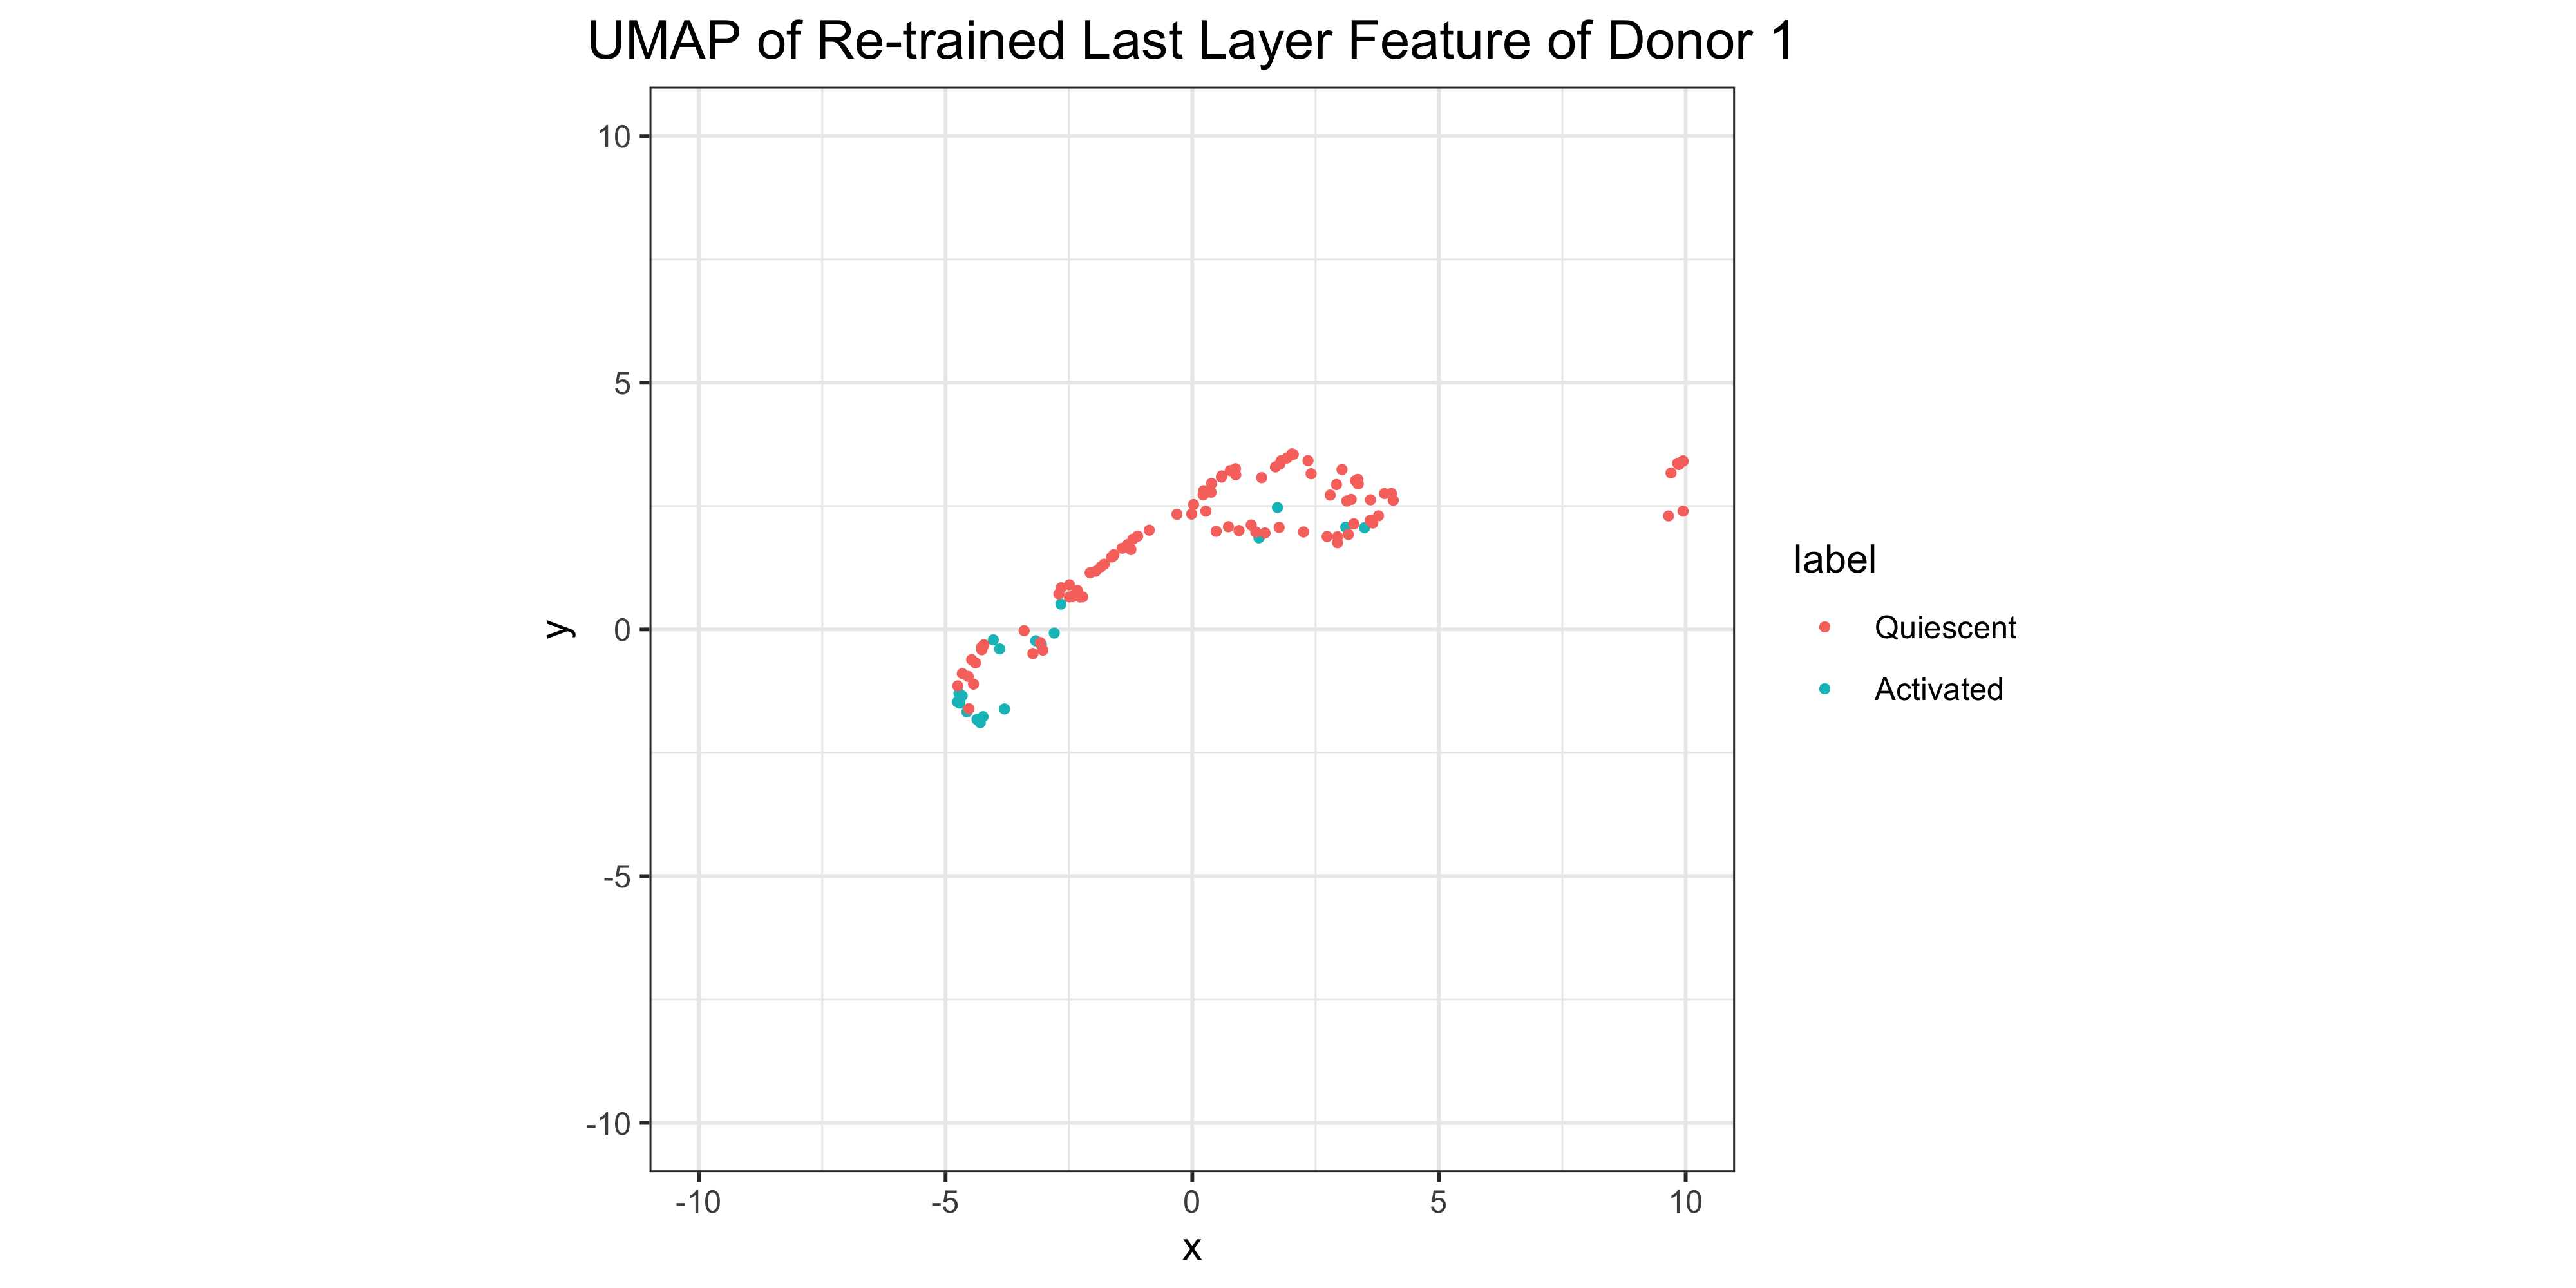

In [44]:
%%R -i umap_2d_df -w 10 -h 5 --units in -r 400

library("ggplot2")

umap_2d_df$label = factor(umap_2d_df$label, levels=c(0, 1),
                          labels=c("Quiescent", "Activated"))

p1 = ggplot(umap_2d_df, aes(x=x, y=y, color=label)) +
    geom_point(size=0.8) +
    xlim(c(-10, 10)) +
    ylim(c(-10, 10)) +
    coord_fixed() +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5, size=15)) +
    ggtitle("UMAP of Re-trained Last Layer Feature of Donor 1")
p1

Feature cluster visualization can help us diagnose machine learning models. From this 2D UMAP scatter plot above, we can see there are roughly two clusters, and one of them (upper right) almost only includes quiescent instances. The small cluster of activated images is not perfectly separated from the quiescent dots, which might explain the low average precision (58.75%) for this model.

Training on the full dataset (10 times more training data) will form two clearly separated clusters, where each corresponds to an cell activity label.

### 4.2. Temperature Scaling

For classification problems, people are usually interested in model's prediction confidence. We have softmax activation on the output layer. Softmax scores fall in the range of $\left(0, 1\right)$ which could be treated as the output probability, but studies have shown this calibration is overconfident.

One easy alternative is to apply temperature scaling. The idea of this method is to use a variable $T$ to scale the logit, input value of the softmax function, before computing its softmax score. The variable $T$ is chosen to  optimize the Negative log likelihood (NLL) on the validation set, where NLL can indirectly measure model's calibration quality.

In the outer loop of our nested-cross validation, we have recorded the validation set for early stopping. In this section, we will use images in this validation set to choose $T$ and then compute a scaled softmax score as the classification confidence.

In [45]:
# We define the following three variables instead of using constants here,
# so you can modify the code to a function if that fits your workflow.
donor = 1
pre_layer = 'mixed8'
num_layer = 2

# Load the lower layers
bottom_model = create_model_multiple_layers(num_layer)
bottom_model.load_weights('./resource/saved_weights_donor_1.h5')

before_last_layer_model = Model(inputs=bottom_model.input,
                                outputs=bottom_model.layers[-2].output)

# Get logits from this network
# One way is to manually do the linear algebra -> weights * layer output + bias
# Another way is to swap the last layer activation function, so predict() gives
# the logits
bottom_model.layers[-1].activation = activations.linear
bottom_model = utils.apply_modifications(bottom_model)

/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [46]:
# Load validation set information
results = load(open('./resource/transfer_test_result.json', 'r'))
vali_names = set(results[str(donor)]['vali_name'])

# For example, when we test donor 1, we are training on donors 2, 3, 5, 6,
# so we need to load those bottlenecks
vali_bottlenecks, vali_labels = [], []

for cur_did in [i for i in [1, 2, 3, 5, 6] if i != donor]:
    # Load bottlenecks
    bottleneck_file_name = 'bottleneck_{}_donor_{}.npz'.format(pre_layer, cur_did)
    bottlenecks = np.load('./images/sample_images/bottlenecks/{}'.format(
        bottleneck_file_name))
    bottleneck_names = bottlenecks['names']
    bottleneck_features = bottlenecks['features']
    bottleneck_labels = bottlenecks['labels']

    # Sample bottleneck features for images in the validation set
    for i in range(len(bottleneck_names)):
        cur_name = bottleneck_names[i]
        if cur_name in vali_names:
            vali_bottlenecks.append(bottleneck_features[i])
            vali_labels.append(bottleneck_labels[i])

print("vali_name length = {}, vali_bottlenecks length = {}.".format(
    len(vali_names), len(vali_bottlenecks)))

vali_name length = 111, vali_bottlenecks length = 111.


In [47]:
# Convert the label to one-hot encoding
vali_labels_onehot = np.vstack([[0, 1] if i == 1 else [1, 0] for i in vali_labels])

# Extract the logits using those vali_bottlenecks
vali_bottlenecks = np.stack(vali_bottlenecks)
vali_logits = bottom_model.predict(vali_bottlenecks)
vali_logits.shape

(111, 2)

In [48]:
# Jupyter-specific issue:
# It is very important to separate our tf code from the keras code. It could
# mess up the underlying graphs in keras' scope.
#
# One way is to use tf.reset_default_graph(), but it has undefined behavior with
# keras graph (especially K.clear_session())
# https://stackoverflow.com/a/50047139/5379444
#
# Here we create a new graph scope for the optimizaiton code. If you are running
# this single cell in a script, then you don't need to create a new tf.Graph().

with tf.Graph().as_default():

    # Then we use TF to find T which minimizes the negative log likelihood
    # Note that temperature > 0
    temperature = tf.Variable(initial_value=tf.random_uniform([1], 0, 10),
                              name='temperature')

    # Combine softmax and lln using softmax_cross_entory according to:
    # https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py
    loss = tf.losses.softmax_cross_entropy(vali_labels_onehot,
                                           vali_logits / temperature)

    # Use tensorflow to optimize our loss function
    train_step = tf.contrib.opt.ScipyOptimizerInterface(
                    loss,
                    method='L-BFGS-B',
                    options={'maxiter': 100})

    optimal_temperature = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_step.minimize(sess)
        optimal_temperature = sess.run(temperature)[0]

    print("The optimal temperature for donor {} is {}".format(
        donor, optimal_temperature))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.151641
  Number of iterations: 5
  Number of functions evaluations: 8
The optimal temperature for donor 1 is 5.285531997680664


After getting $T$, we can write a function to compute the temperature scaled softmax score.

In [49]:
def get_confidence(bottlenecks, num_layer, weight_file, temperature):
    """
    Compute the temperature scaled classification confidence score for the
    given image using given model with weights.

    Args:
        bottlenecks(np.array(bottleneck)): batch of bottlenecks: each bottleneck
            is the extracted feature for one image
        num_layer(int): number of retraining layers, this is the same argument
            in retrain() function
        weight_file(str): paht to the h5 file with re-trained weights
        temperature(float): the temperature score used to scale the logits before
            computing the softmax. It should be selected to optimize NLL on the
            validation set.
            
    Returns:
        confidences(np.array([conf_0, conf_1])): batches of confidence scores:
            conf_0 is the confidence of positive classification. conf_0 and
            conf_1 sum to 1.
            
    """
    
    # Create a network to extract logits for this bottleneck
    bottom_model = create_model_multiple_layers(num_layer)
    bottom_model.load_weights(weight_file)

    bottom_model.layers[-1].activation = activations.linear
    bottom_model = utils.apply_modifications(bottom_model)
    
    # Get the logits
    logit = bottom_model.predict(bottlenecks)
    
    # Get the scaled softmax            
    confidences = softmax(logit/temperature)
    
    return confidences

In [50]:
# Test computing the confidence
get_confidence(np.array([vali_bottlenecks[0]]), num_layer,
               './resource/saved_weights_donor_1.h5',
               optimal_temperature)

array([[0.00245888, 0.9975412 ]], dtype=float32)

Based on the result above, we can report that the negative classification of `vali_bottlenecks[0]` has confidence 99.74%.

### 4.3. Misclassified Image Visualization

Visualizing which images get misclassified in the test set can help us gain more insights regarding the classifier as well as our dataset. If our classifier tends to make mistakes on certain type of images, we could perhaps modify the image processing pipeline to further improve the model performance.

In [51]:
# Get misclassified image list
results = load(open('./resource/transfer_test_result.json', 'r'))
test_names = np.array(results[str(donor)]['y_true_name'])
y_true = np.array(results[str(donor)]['y_true'])
y_score = results[str(donor)]['y_score']
y_pred = np.array([1 if i >= 0.5 else 0 for i in y_score])
error_names = test_names[y_pred != y_true]

# Double check if we count errors correctly
print("Error proportion = {:.4f}, (1 - acc) = {:.4f}.".format(
    len(error_names)/len(y_true), 1 - results[str(donor)]['acc']))

error_names = set(error_names)
error_names

Error proportion = 0.1135, (1 - acc) = 0.1135.


{'CD3_1_act_9_1_12.png',
 'CD3_1_act_9_4_16.png',
 'CD3_1_act_9_6_3.png',
 'CD3_1_noact_10_2_139.png',
 'CD3_1_noact_10_5_4.png',
 'CD8_1_act_4_2_11.png',
 'CD8_1_act_4_2_14.png',
 'CD8_1_act_4_4_1.png',
 'CD8_1_act_4_5_4.png',
 'CD8_1_noact_2_1_147.png',
 'CD8_1_noact_2_1_38.png',
 'CD8_1_noact_2_2_29.png',
 'CD8_1_noact_2_2_41.png',
 'CD8_1_noact_2_2_74.png',
 'CD8_1_noact_2_2_80.png',
 'CD8_1_noact_2_2_82.png',
 'CD8_1_noact_2_2_86.png',
 'CD8_1_noact_2_3_30.png',
 'CD8_1_noact_2_3_34.png',
 'CD8_1_noact_2_3_5.png',
 'CD8_1_noact_2_3_59.png'}

In [52]:
# Sample bottlenecks for these error images
error_bottlenecks, error_bottlenecks_names = [], []

bottleneck_file_name = 'bottleneck_{}_donor_{}.npz'.format(pre_layer, donor)
bottlenecks = np.load('./images/sample_images/bottlenecks/{}'.format(
    bottleneck_file_name))
bottleneck_names = bottlenecks['names']
bottleneck_features = bottlenecks['features']

for i in range(len(bottleneck_names)):
    if bottleneck_names[i] in error_names:
        error_bottlenecks.append(bottleneck_features[i])
        error_bottlenecks_names.append(bottleneck_names[i])

# Get the temperature scaled confidence
error_bottlenecks = np.stack(error_bottlenecks)
error_confidences = get_confidence(error_bottlenecks, num_layer,
                                   './resource/saved_weights_donor_1.h5',
                                   optimal_temperature)

error_confidences

array([[9.89344299e-01, 1.06557226e-02],
       [9.00053382e-01, 9.99466702e-02],
       [9.97807562e-01, 2.19245651e-03],
       [5.26745677e-01, 4.73254293e-01],
       [6.32344127e-01, 3.67655843e-01],
       [7.00260818e-01, 2.99739182e-01],
       [1.00000000e+00, 2.93454524e-13],
       [3.50646913e-01, 6.49353087e-01],
       [4.18211401e-01, 5.81788599e-01],
       [2.42336616e-01, 7.57663369e-01],
       [1.43545702e-01, 8.56454313e-01],
       [1.78160563e-01, 8.21839452e-01],
       [3.01174998e-01, 6.98825002e-01],
       [4.92496461e-01, 5.07503510e-01],
       [3.76243889e-02, 9.62375641e-01],
       [2.79509518e-02, 9.72048998e-01],
       [3.91917169e-01, 6.08082831e-01],
       [1.04670655e-02, 9.89532948e-01],
       [1.10707954e-01, 8.89292002e-01],
       [2.07082286e-01, 7.92917728e-01],
       [2.84354895e-01, 7.15645134e-01]], dtype=float32)

In [53]:
def quick_write(img, text, location):
    """
    A wrapper function to add text on image using openCV. This function does not
    return anything. It writes on the img directly.
    
    Args:
        img(np.array): image pixel matrix
        text(str): the text to write on
        location((int, int)): the text location
    """
    
    cv2.putText(img, text, location, cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 255, 255), 2, cv2.LINE_AA)

In [54]:
def montage_images(img_list, n_col, image_size=50, margin=2):
    """
    Plot all the images listed in `img_names` in a gird with `n_col` columns.
    Images will be resized to `image_size`*`image_size`.
    This function assumes input images have the same shape.
    
    Args:
        img_list([np.array]): list of image pixel matrices
        n_col(int): number of images in one row
        image_size(int): the length of each image on the montage view
        margin(int): the horizonal and vertical gap between image image
        
    Returns:
        np.array: The montage view of all images listed in `img_names`
    """
    temp_img_list = [cv2.resize(i, (image_size, image_size)) for i in img_list]
    stack = np.hstack(temp_img_list)

    # Compute number of rows
    n_row = math.ceil(len(img_list) / n_col)
    image = np.ones((n_row * image_size + (n_row - 1) * margin,
                     n_col * image_size + (n_col - 1) * margin)) * 255

    for i in range(int(stack.shape[1] / image_size)):
        r, c = i // n_col, i % n_col
        image[image_size * r + r * margin : image_size * (r + 1) + r * margin,
              image_size * c + c * margin : image_size * (c + 1) + c * margin
             ] = stack[:, image_size * i : image_size * (i + 1)]
        
    return image

In [55]:
edited_image_list = []

# Write predictive score on the error image
for i in range(len(error_bottlenecks_names)):
    name = error_bottlenecks_names[i]
    confidence = error_confidences[i]

    # Find the image path
    if "noact" in name:
        cur_dir = './images/sample_images/processed/augmented/donor_{}/quiescent'.\
            format(donor)
        predict = "Activated"
    else:
        cur_dir = './images/sample_images/processed/augmented/donor_{}/activated'.\
            format(donor)
        predict = "Quiescent"
        
    # Load the image
    img_gray = cv2.imread(join(cur_dir, name), 0)
    img = cv2.resize(img_gray, (512, 512))
    
    # Add text label
    quick_write(img, 'Wrong Prediction: {}'.format(predict), (42, 450))
    quick_write(img, 'Confidence: {0:.2f}, {1:.2f}'.format(*confidence),
                (135, 490))
    
    edited_image_list.append(img)

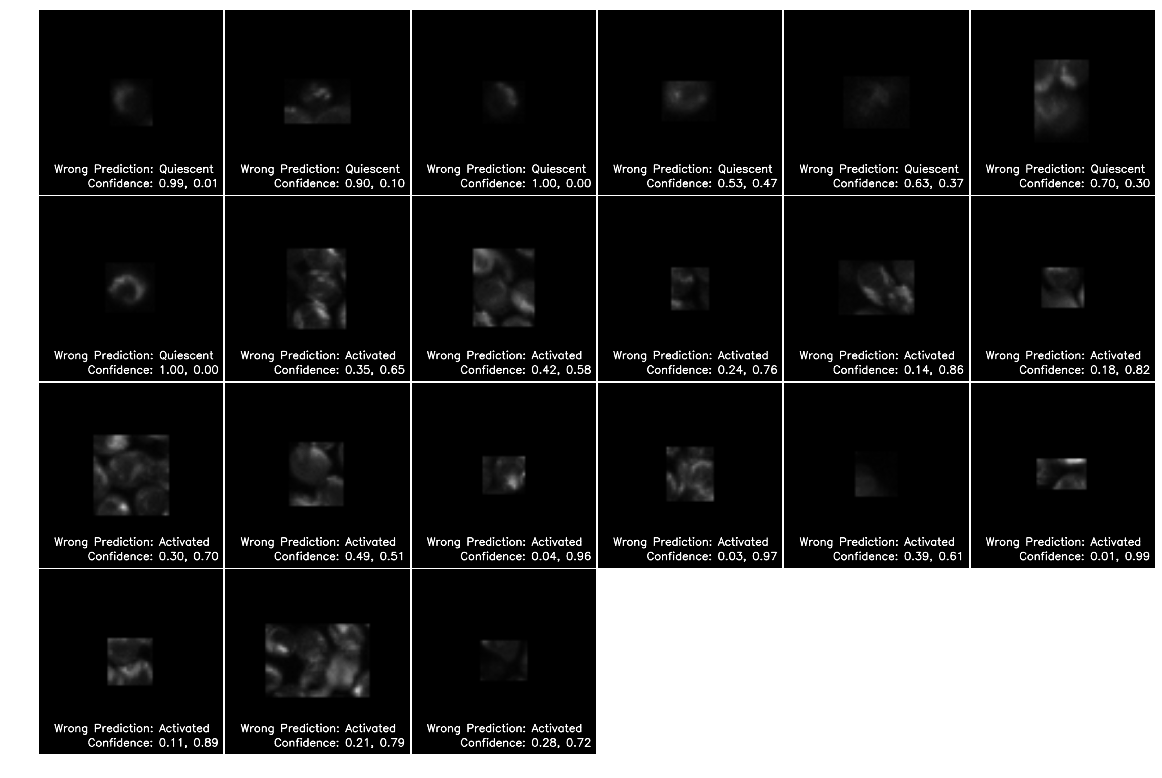

In [56]:
# Montage all images
montage = montage_images(edited_image_list, 6, image_size=1024, margin=10)

plt.figure(figsize=(20, round(montage.shape[1] / montage.shape[0] * 20)))
plt.imshow(montage, cmap='gray')
plt.axis('off')
plt.show()

One interesting pattern above is that our model tends to predict images with multiple cells as activated when the image is actually labeled as quiescent.

### 4.4. Saliency Map

Saliency map is a technique to visualize the regions in the image where a small change can greatly influence the classification result. It helps us learn where the network pays attention to on the image. It is useful to diagnose our model and sometimes gain insights of the images.

In this section, we will use Python package `keras-vis` to plot the saliency map for some donor 1 images. Since we are changing the model structure (only working on lower levels), it is tricky to use `keras-vis` directly. One workaround is to use a full Inception v3 with Imagenet weights as the base model, and then copy the newly trained weights onto retrained lowers layers of the base model.

In [57]:
def get_combined_model(num_layer, weights_file):
    """
    Load retrained weights on lower layers of a complete Inception V3 model with
    imagenet weights.
    
    Args:
        num_layer(int): number of retraining layers, this is the same argument
            in retrain() function
        weight_file(str): paht to the h5 file with re-trained weights
        
    Returns:
        combined_model: a complete Inception V3 keras model with imagenet
            weights where lower layers (specified by `num_layer`) have retrained
            weights loaded from weights_file
    """
    
    # Get the imagenet base model
    base_model = InceptionV3(weights='imagenet', include_top=False,
                             input_shape=(299, 299, 3))
    
    # Get the retrained model and its weights
    bottom_model = create_model_multiple_layers(num_layer)
    bottom_model.load_weights(weights_file)
    
    # Fill the combined model (no retrained weights yet)
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    predictions = Dense(2, activation="softmax", name="prediction")(x)
    combined_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Update weights in combined model
    layer_len = len(bottom_model.layers)
    print("Num of layers: {}".format(layer_len))

    retrained_layers = combined_model.layers[-layer_len:]

    # Update lower level weights in the base model
    # We start from 1 to skip the input layer of our customed model
    for i in range(1, len(retrained_layers)):
        weight_list_1 = retrained_layers[i].get_weights()
        weight_list_2 = bottom_model.layers[i].get_weights()
        assert(len(weight_list_1) == len(weight_list_2))
        
        if len(weight_list_1) > 0:
            assert(weight_list_1[0].shape == weight_list_2[0].shape)

        retrained_layers[i].set_weights(
            bottom_model.layers[i].get_weights()
        )

    combined_model.layers[-layer_len:] = retrained_layers
    
    return combined_model

In [58]:
combined_model = get_combined_model(num_layer,
                                    './resource/saved_weights_donor_1.h5')

Num of layers: 65


In [59]:
# Swap the output softmax with linear
layer_idx = utils.find_layer_idx(combined_model, 'prediction')
combined_model.layers[layer_idx].activation = activations.linear
combined_model = utils.apply_modifications(combined_model)

In [60]:
# Visualize the saliency map for a few donor 1 images
image_list = ['./images/sample_images/processed/augmented/donor_1/activated/' +
              'CD3_1_act_9_6_33.png',
              './images/sample_images/processed/augmented/donor_1/quiescent/' +
              'CD3_1_noact_10_1_57.png']

original, guided = [], []

for image in image_list:
    img_gray = cv2.imread(image, 0)
    original.append(img_gray)
    
    # Resize it to fit the base model input size
    img = np.array([resize(img_gray, (299, 299, 3))])
    index = 0 if "noact" in image else 1
    grads = visualize_saliency(combined_model, layer_idx, filter_indices=index,
                               seed_input=img, backprop_modifier="guided")
    guided.append(grads)

/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/JayWong/miniconda3/envs/cellimage/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


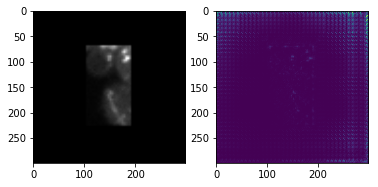

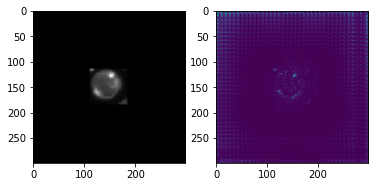

In [61]:
for i in range(len(image_list)):
    f, ax = plt.subplots(1, 2)
    cur_ori = resize(original[i], (299, 299)) * 255
    ax[0].imshow(cur_ori, cmap='gray') 
    ax[1].imshow(guided[i], cmap='viridis')

We can see our model learns to focus on high-intensity regions on the cell.

In [62]:
# Clean memory use of section 4
del (bottom_model, extract_model, all_inputs, all_names, all_labels,
     interested_inputs, interested_names, interested_labels, extracted_features)

del (before_last_layer_model, results, vali_bottlenecks, vali_labels,
     vali_names, bottlenecks, bottleneck_names, bottleneck_features,
     bottleneck_labels, vali_labels_onehot, vali_logits)

del (test_names, y_true, y_score, y_pred, error_names, error_bottlenecks,
     error_bottlenecks_names, error_confidences, img_gray, edited_image_list,
     montage, combined_model, original, guided)

## 5. Model Comparison

In this section, we use visualization to compare the test results on five test donors of all classifiers: [frequency classifier](./frequency_classifier.ipynb), [logistic regressions](./logistic_regression.ipynb), [simple neural network](./simple_neural_network.ipynb), [simple CNN](./simple_cnn_lenet.ipynb), and transfer learning.

In [63]:
# Build a big dataframe containing all the test results
summary_dict = {
    'method': [],
    'donor': [],
    'auc': [],
    'ap': [],
    'acc': []
}

# Frequency classifier
fq_model_performance = np.load('./resource/frequency_model_performance.npz')
fq_model_performance = fq_model_performance['model_performance'].item()
cur_method = 'Frequency Classifier'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(fq_model_performance[d]['aroc'])
    summary_dict['ap'].append(fq_model_performance[d]['ap'])
    summary_dict['acc'].append(fq_model_performance[d]['acc'])

# Three logistic regressions
npz_data = np.load('./resource/lr_model_performance.npz')
performance_collection_dict = npz_data['performance_collection_dict'].item()

for m in performance_collection_dict:
    for d in [1, 2, 3, 5, 6]:
        cur_model = performance_collection_dict[m]
        summary_dict['method'].append(m)
        summary_dict['donor'].append(d)
        summary_dict['auc'].append(cur_model[d]['aroc'])
        summary_dict['ap'].append(cur_model[d]['ap'])
        summary_dict['acc'].append(cur_model[d]['acc'])

# Simple neural network
results = load(open('./resource/nn_test_result.json', 'r'))
cur_method = 'Simple Neural Network'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['aroc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])

# Simple CNN
results = load(open('./resource/lenet_test_result.json', 'r'))
cur_method = 'Simple CNN'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['aroc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])

# Transfer learning
results = load(open('./resource/transfer_test_result.json', 'r'))
cur_method = 'Transfer Learning'

for d in [1, 2, 3, 5, 6]:
    summary_dict['method'].append(cur_method)
    summary_dict['donor'].append(d)
    summary_dict['auc'].append(results[str(d)]['auc'])
    summary_dict['ap'].append(results[str(d)]['ap'])
    summary_dict['acc'].append(results[str(d)]['acc'])
    
metric_df = pd.DataFrame(summary_dict)
metric_df

,method,donor,auc,ap,acc
0,Frequency Classifier,1,0.500000,0.118919,0.881081
1,Frequency Classifier,2,0.500000,0.812500,0.187500
2,Frequency Classifier,3,0.500000,0.265896,0.734104
3,Frequency Classifier,5,0.500000,0.728261,0.271739
4,Frequency Classifier,6,0.500000,0.431373,0.568627
5,LR (Intensities),1,0.737033,0.461245,0.659459
6,LR (Intensities),2,0.712821,0.924718,0.600000
7,LR (Intensities),3,0.871448,0.786678,0.710983
8,LR (Intensities),5,0.746866,0.906287,0.673913
9,LR (Intensities),6,0.896944,0.893820,0.813725


In [64]:
# Count the lables for each donor
count_dict = {}

for d in [1, 2, 3, 5, 6]:
    # Do not count augmented images
    act_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/activated/*.png".format(d))) // 6
    qui_count = len(glob("./images/sample_images/processed/" +
                         "augmented/donor_{}/quiescent/*.png".format(d))) // 6
    count_dict[d] = {
        'activated': act_count,
        'quiescent': qui_count
    }

count_r_dict = {'count': [], 'donor': [], 'variable': []}
for v in ['Activated', 'Quiescent']:
    for d in [1, 2, 3, 5, 6]:
        count_r_dict['count'].append(
            count_dict[d]['activated'if v == 'Activated' else 'quiescent']
        )
        count_r_dict['donor'].append(d)
        count_r_dict['variable'].append(v)
count_df = pd.DataFrame(count_r_dict)
count_df

,count,donor,variable
0,22,1,Activated
1,65,2,Activated
2,46,3,Activated
3,67,5,Activated
4,44,6,Activated
5,163,1,Quiescent
6,15,2,Quiescent
7,127,3,Quiescent
8,25,5,Quiescent
9,58,6,Quiescent


In [65]:
%reload_ext rpy2.ipython

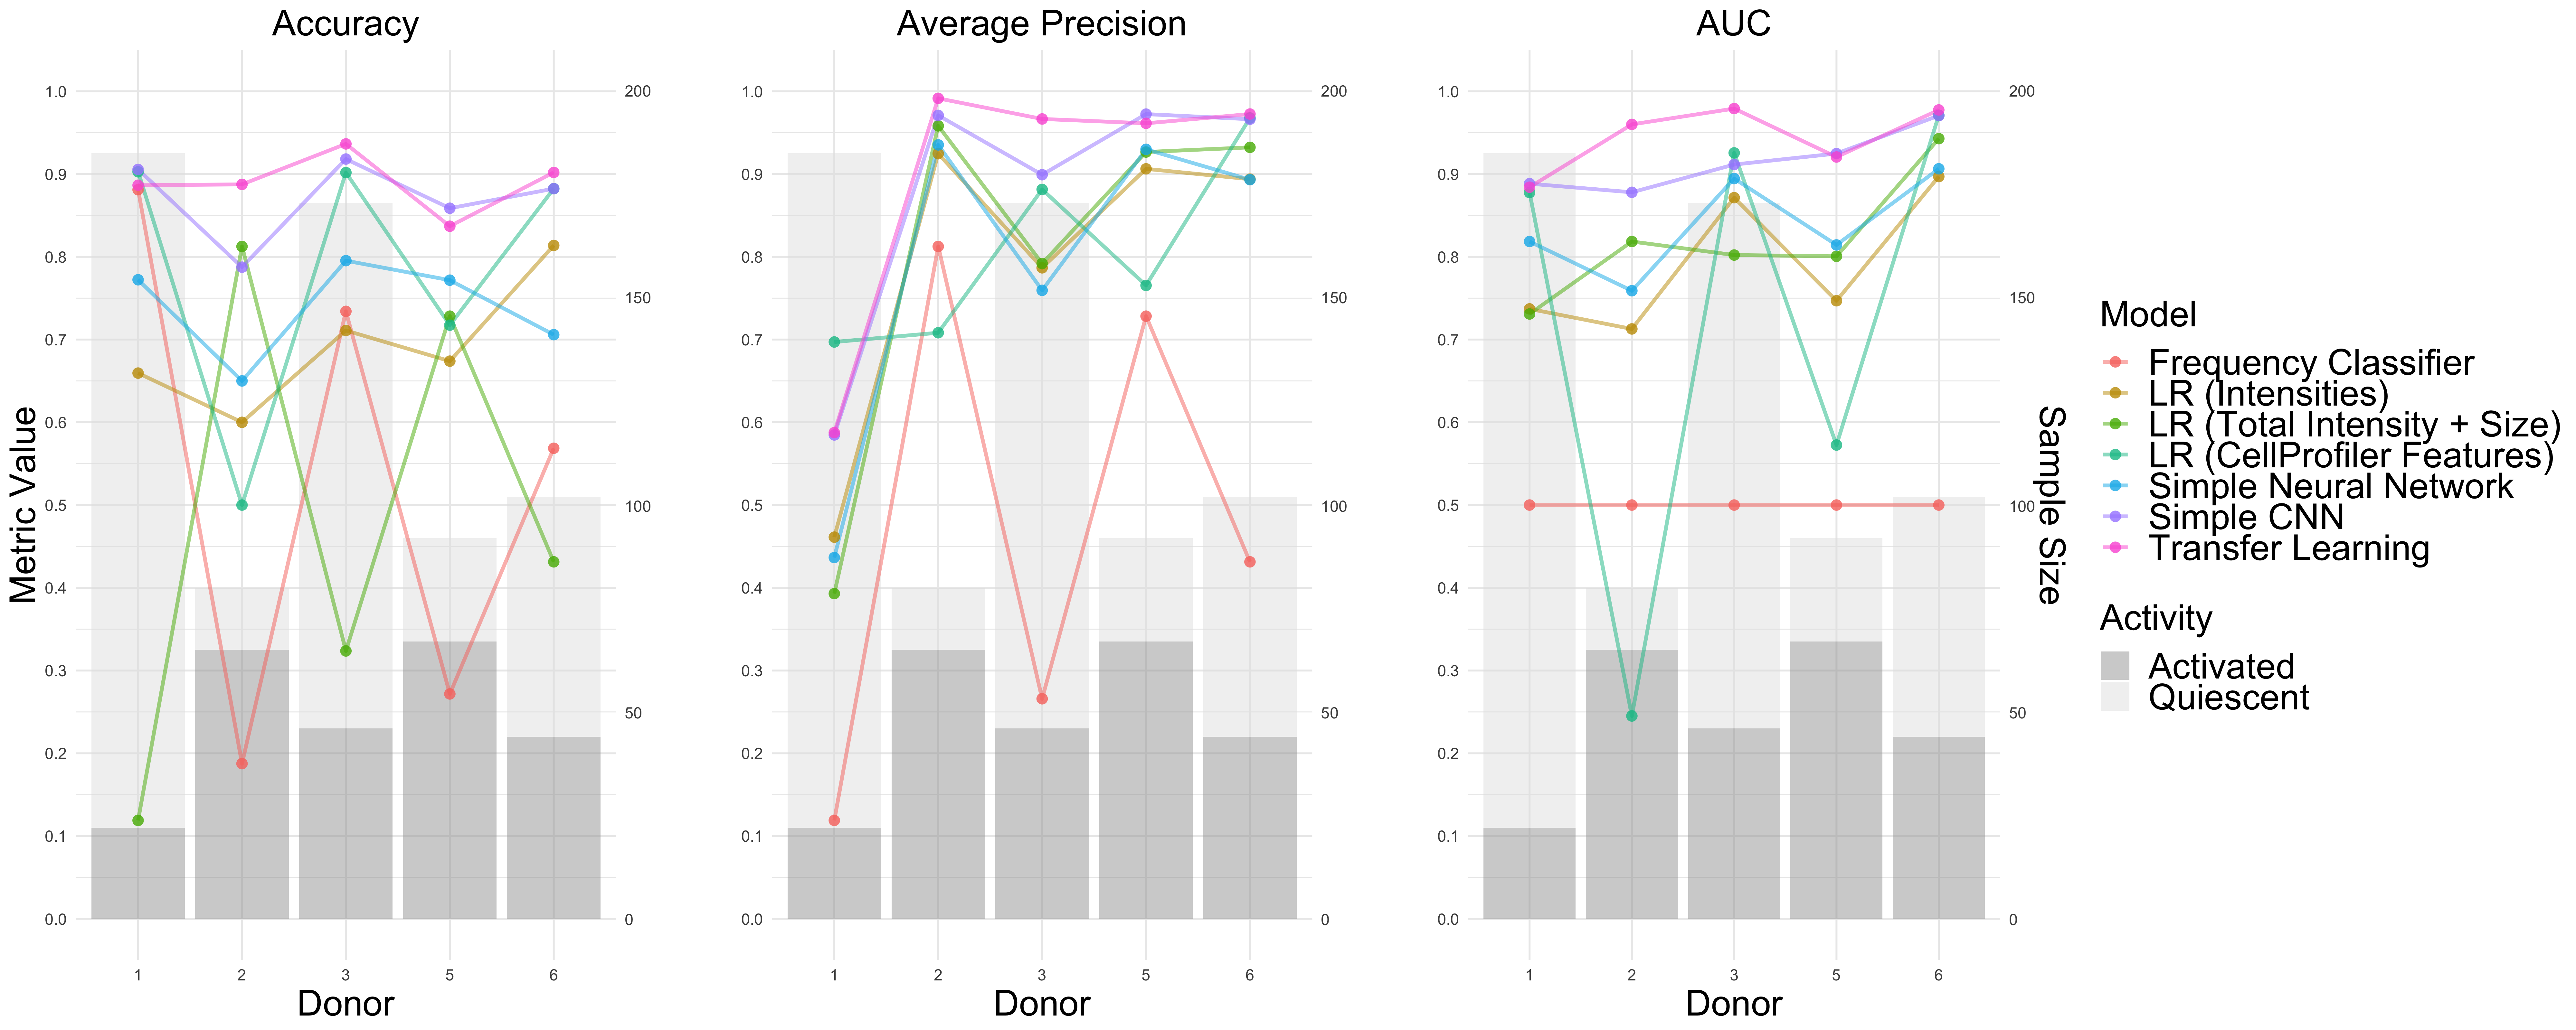

In [66]:
%%R -i metric_df,count_df -w 20 -h 8 --units in -r 400

library("magrittr")
library("ggplot2")
library("ggpubr")

level_order = c("Frequency Classifier",
                "LR (Intensities)",
                "LR (Total Intensity + Size)",
                "LR (CellProfiler Features)",
                "Simple Neural Network",
                "Simple CNN",
                "Transfer Learning")

# Convert discrete columns into R factors
metric_df$donor = factor(metric_df$donor)
metric_df$method = factor(metric_df$method, levels=level_order)
count_df$variable = factor(count_df$variable)
count_df$donor = factor(count_df$donor)

line_size = 1
point_size = 3

# Accuracy plot
p1 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name=""),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=acc, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=acc, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("Accuracy") +
    labs(color="Model", fill="Activity", x="Donor",
         y="Metric Value") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.position = 'none') 

# AP plot
p2 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name=""),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=ap, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=ap, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("Average Precision") +
    labs(color="Model", fill="Activity", x="Donor",
         y="") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.position = 'none') 

# AUC plot
p3 = ggplot() +
    scale_y_continuous(sec.axis = sec_axis(~ 200*., name="Sample Size"),
                       breaks = scales::pretty_breaks(n = 10),
                       limits = c(0, 1)) +
    geom_col(data=count_df, aes(x=donor, y=count/200, fill=variable),
             position = position_stack(reverse = TRUE)) +
    geom_line(data=metric_df, aes(x=donor, y=auc, color=method, group=method),
              size=line_size, alpha=0.5) +
    geom_point(data=metric_df, aes(x=donor, y=auc, color=method),
               size=point_size, alpha=0.8, stroke=0) +
    scale_fill_manual(values=c(alpha("#A2A2A2", 0.5), alpha("#E3E3E3", 0.5))) +
    ggtitle("AUC") +
    labs(color="Model", fill="Activity", x="Donor",
         y="") +
    theme_minimal()+
    theme(plot.title = element_text(hjust = 0.5, size=20),
          axis.title = element_text(size = 20),
          legend.title = element_text(size = 20), 
          legend.text = element_text(size = 20))

# There is a bug of calling ggarrange with common legend in R magic, we
# only plot legend for AUC and manully set up widths here
# ggarrange(p1, p2, p3, ncol=3, legend='right', common.legend=TRUE)
ggarrange(p1, p2, p3, ncol=3, widths=c(1,1,1.7))

This visualization gives a nice view of three metrics of 7 classifiers on 5 donors. It also includes the cell type counts which help us inference the relationship between performance and data skewness.

Even tough we are only working on a small subset of images, we can see the performance improves when we are using more complex models, and the transfer learning model dominates across all metrics and all test donors.

In [67]:
# Clean memory use of section 5

del summary_dict

## 6. Final Evaluation on Held-out Donor 4

After finalizing our [data processing procedures](./image_processing.ipynb) along with the pipelines for training different classifiers ([frequency classifier](./frequency_classifier.ipynb), [logistic regressions](./logistic_regression.ipynb), [simple neural network](./simple_neural_network.ipynb), [simple CNN](./simple_cnn_lenet.ipynb), and transfer learning), we can finally use our best practice to test the held-out images from donor 4.

In this set up, we will use the same nested-cross validation scheme to select transfer learning hyper-parameters (inner loop), and then evaluate the fine-tuned model on donor 4.

### 6.1. Extract Bottlenecks

First, we want to extract bottlenecks for donor 4 as what we did for other donors in [1.1. Extract Bottlenecks](#1.1.-Extract-Bottlenecks).

In [68]:
# make_bottleneck_main('mixed9', donors=[4])
# make_bottleneck_main('mixed8', donors=[4])

### 6.2. Model Tuning

Then, we apply the same nested-cross validation code here to find the optimal hyper-parameters for donor 4. One should note that since we are now using 6 donors in total, for each hyper-parameter combination, there are 5 iterations(runs) in the inner loop, which used to be 4. Similarly, there will be more training data in the outer loop when we evaluate the final performance.

Below is the code to tune donor 4's model with the same hyper-parameter space as in [2.3. Nested Cross-validation](#2.3.-Nested-Cross-validation). It is very slow to run in this notebook, so we have split it into $2 \times 2 \times 2 \times 1 \times 5 = 40$ jobs and run them externally with `epoch=500`. The tuning results is provided at `./resource/transfer_tune_result_donor_4.csv`.

In [69]:
layer_candidates = ['mixed8', 'mixed9']
lr_candidates = [0.001, 0.01]
bs_candidates = [16, 32]

# Grid search the best parameter
donors = [1, 2, 3, 4, 5, 6]
for layer in layer_candidates:
    for lr in lr_candidates:
        for bs in bs_candidates:
            test_did = 4
            for vali_did in [i for i in donors if i != test_did]:
                pass
#                cross_validation_main(layer, lr, bs, epoch=500,
#                                      test_did=test_did, vali_did=vali_did)

In [70]:
tuning_result = pd.read_csv('./resource/transfer_tune_result_d4.csv')

# It has 2 * 2 * 2 = 8 rows
print(tuning_result.shape)
tuning_result

(8, 7)


,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
0,4,mixed8,0.001,16,0.904782,0.908697,0.952301
1,4,mixed8,0.001,32,0.868371,0.920524,0.949996
2,4,mixed8,0.010,16,0.764253,0.892270,0.858263
3,4,mixed8,0.010,32,0.898609,0.917330,0.951372
4,4,mixed9,0.001,16,0.902706,0.920721,0.942268
5,4,mixed9,0.001,32,0.896058,0.916048,0.932280
6,4,mixed9,0.010,16,0.905030,0.906684,0.945728
7,4,mixed9,0.010,32,0.902066,0.908384,0.937703


In [71]:
# Iterate through all the rows in the dataframe, and find the row which
# has the largest average of average precision for each test donor
best_row = {}

for i, r in tuning_result.iterrows():
    tid = r['Test Donor']
    ap = r['Average of Average Precison']
    
    if tid not in best_row:
        best_row[tid] = (i, ap)
        continue
    
    if ap > best_row[tid][1]:
        best_row[tid] = (i, ap)

best_para_df = tuning_result.iloc[[best_row[i][0] for i in best_row], :]

# Get the best parameter for each test donor [lr, bs, pre_layer]
best_parameters = {}
for i, r in best_para_df.iterrows():
    best_parameters[r['Test Donor']] = [r['Learning Rate'], r['Batch Size'],
                                        r['Pre-layer']]
    
best_para_df

,Test Donor,Pre-layer,Learning Rate,Batch Size,Average of Accuracy,Average of Average Precison,Average of AUC
4,4,mixed9,0.001,16,0.902706,0.920721,0.942268


In [72]:
best_parameters

{4: [0.001, 16, 'mixed9']}

### 6.3. Model Testing

After tuning the transfer learning model for donor 4, we test it using the nested-cross validation outer loop.

In [75]:
# Remove the checkpoint in ./temp if you have run retrain() in previsous cells
if exists('./temp/retrain_config.json'):
    os.remove('./temp/retrain_config.json')

# leave_one_out_main('mixed9', 0.001, 16, 4, epoch=1, donors=[1, 2, 3, 4, 5, 6])

The testing results of `epoch=500` is included at `./resource/transfer_test_result_d4.json`.

In [74]:
result = load(open('./resource/transfer_test_result_d4.json', 'r'))[str((4, -1))]

# Compute precision and recall
cur_pred = [1 if i >= 0.5 else 0 for i in result['y_score']]
cur_precision = metrics.precision_score(result['y_true'], cur_pred)
cur_recall = metrics.recall_score(result['y_true'], cur_pred)

# Compute the image size for donor 4
# Do not count augmented images
act_count = len(glob("./images/sample_images/processed/" +
                     "augmented/donor_4/activated/*.png")) // 6
qui_count = len(glob("./images/sample_images/processed/" +
                     "augmented/donor_4/quiescent/*.png")) // 6


df = pd.DataFrame({
    'Test Donor': [4],
    'Accuracy': [result['acc']],
    'Precision': [cur_precision],
    'Recall': [cur_recall],
    'Average Precision': [result['ap']],
    'AUC': [result['auc']],
    'Num of Activated': [act_count],
    'Num of Quiescent': [qui_count]
})

df

,Test Donor,Accuracy,Precision,Recall,Average Precision,AUC,Num of Activated,Num of Quiescent
0,4,0.990521,0.979592,0.979592,0.987797,0.995339,49,162


The final performance on test donor 4 is higher than all other test donors. One factor is that donor 4's model is tuned and trained on more images across more donors.

## 7. Summary

In this notebook, we applied the same nested-cross validation scheme to tune and evaluate a transfer learning classifier. Then, we use UMAP clustering, temperature scaling, and saliency map to interpret and diagnose this model. Finally, after comparing all the models we have discussed in this repository, we tested our best model on the held-out donor 4.